This notebook takes the files that were not used to create the word list in the find_words notebook and vectorizes them so they can be fed through models. Still working on a way to effectively safe this numerical data, but I may only be able to do that with binary data.

In [4]:
import os
import json
import numpy as np
import pandas as pd
import pyarrow as pa
from pandas.io.json import json_normalize
import cryptography
import re
from cryptography.fernet import Fernet
import bs4
from nltk.tokenize import word_tokenize
from nltk.metrics import edit_distance
import pickle
from collections import Counter
import matplotlib.pyplot as plt

In [5]:
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def tokenize(text):
    text = re.sub('&quot;','\'',text)
    text = re.sub('&amp;','&',text)
    text = re.sub('"', '', text)
    text = re.sub(r'\'(?!\')(.*)\'',r'\0', text)
    
    toks = re.split(r'[\s,:;{}\(\)<>\/�]+',text.lower())
    return sorted(toks)

In [6]:
vocab = [a for a,b in load_obj('sorted_kvpairs_url')]
vocab = sorted(vocab[:10000])#takes the top 10000 by freq and puts them in alphabetical/ascii order

In [7]:
# Create corpus
data = []
labels = []
indicators=[]
url= []
url_to_ind_distance = []
text_len = []
# Not included as all their files seem to be empty or they have no enrichment: 
    #4/5, 4/6, 4/13, 4/14, 4/15, 4/31, 5/13, 5/14, 5/15, 5/16, 5/17, 5/18, 7/4, 7/5, 7/6
# Empty List serves as a place holder between the data used in find_words and the test data I'm using here
date_batches = [['newbenigndata'],['2019-04-22','2019-04-23','2019-04-24','2019-04-25','2019-04-26','2019-04-27','2019-04-28','2019-04-29'],
                ['2019-04-11','2019-04-12','2019-04-16','2019-04-17','2019-04-18','2019-04-19','2019-04-20','2019-04-21'],
                ['2019-04-30','2019-05-01','2019-05-02','2019-05-03','2019-05-04'],
                ['2019-05-05','2019-05-06','2019-05-07','2019-05-08','2019-05-09','2019-05-10','2019-05-11','2019-05-12'],
                ['2019-05-19','2019-05-20'],
                ['2019-05-21','2019-05-22','2019-05-23','2019-05-24','2019-05-25','2019-05-26','2019-05-27','2019-05-28'],
                ['2019-05-29','2019-05-30','2019-05-31','2019-06-01','2019-06-02','2019-06-03','2019-06-04','2019-06-05'],
                ['2019-06-06','2019-06-07','2019-06-08','2019-06-09','2019-06-10','2019-06-11','2019-06-12','2019-06-13'],[],
                ['2019-06-14', '2019-06-15','2019-06-16', '2019-06-17','2019-06-18','2019-06-19', '2019-06-20', '2019-06-21'],
                ['2019-06-22', '2019-06-23', '2019-06-25', '2019-06-26', '2019-06-27', '2019-06-28','2019-06-29', '2019-06-30'],
                ['2019-07-01','2019-07-02', '2019-07-03', '2019-07-07', '2019-07-09', '2019-07-10'],
                ['newNONTORbenigndata']]
dates = ['2019-07-01']#date_batches[-2]+date_batches[-1]+date_batches[-3]+date_batches[-4]#+date_batches[4]+date_batches[5]+date_batches[6]+date_batches[7]+date_batches[8] 
#'2019-04-12','2019-04-16','2019-04-17','2019-04-18','2019-04-19','2019-04-20','2019-04-21]
for date in dates:
    files = os.listdir('/data/data/'+date+'/enrichment/fetch_page')
    top = len(files)
    if top > 700:
        top = 100
    for j in range(top):
        with open('/data/data/'+date+'/enrichment/fetch_page/'+files[j]) as d:
            r = json.load(d)
            try:
                df = json_normalize(r['data'])
            except:
                break
        try:
            df = df[df['status_code'] == 200].reset_index(drop=True)
            df = df[df['success']]
        except:
            df = df[df['success']]
        #Need to determine label
        html_str = df['page_content'].copy()
        
        for i in range(len(html_str)):
            if df.loc[i,'url'] in url:
                continue
            else:
                url.append(df.loc[i, 'url'])
            if len(files[j]) > 10:
                labels += [1]
            else:
                labels += [0]
            key = bytes( df.loc[i,'encryption_key'],encoding = 'UTF-8')
            f = Fernet(key) 
            #decrypt string
            text = f.decrypt(bytes(html_str[i],encoding='UTF-8'))
            #clean out html
            print(text[:200])
            text = text.decode('utf8')
            print(text[:200])
            text_len.append(len(text))
            url_to_ind_distance.append(edit_distance(df.loc[i,'url'],df.loc[i,'indicator']))

            toks = tokenize(text)
            #need to create vector 
            count = Counter()
            for tok in toks:
                count[tok] += 1
            vec = []
            for v in vocab:
                vec = np.append(vec, [count[v]])
            data.append(vec)
                
            
            
         #end of for
    #end of for
    print('------------'+date+'---------------')
#end of for
data = np.row_stack(data)
data[:2]

b'<!DOCTYPE html><html lang="en" itemType="http://schema.org/WebPage" prefix="og: http://ogp.me/ns#"><head><title data-react-helmet="true" itemProp="name">Gfycat | Find, Make &amp; Share Gfycat GIFs</ti'
<!DOCTYPE html><html lang="en" itemType="http://schema.org/WebPage" prefix="og: http://ogp.me/ns#"><head><title data-react-helmet="true" itemProp="name">Gfycat | Find, Make &amp; Share Gfycat GIFs</ti
b'<!DOCTYPE html>\n<html lang="ja" xmlns:og="http://ogp.me/ns#" xmlns:fb="http://www.facebook.com/2008/fbml">\n<head>\n<title>\xe5\xb9\xb4\xe9\xbd\xa2\xe8\xaa\x8d\xe8\xa8\xbc - FANZA</title>\n<meta name="description" content="\xe6\x88\x90\xe4\xba\xba\xe5\x90\x91\xe3\x81\x91\xe3\x82\xb3\xe3'
<!DOCTYPE html>
<html lang="ja" xmlns:og="http://ogp.me/ns#" xmlns:fb="http://www.facebook.com/2008/fbml">
<head>
<title>年齢認証 - FANZA</title>
<meta name="description" content="成人向けコンテンツを取り扱うアダルト総合サイト。
b'<!DOCTYPE html>\r\n\r\n\r\n    <html class="html__responsive">\r\n\r\n    <head>\r\n\r\n        <tit

b'<!DOCTYPE html><!--\n       .o                                8888       8888\n      .88                                8888       8888\n    o8888oo  ooo  oooo  ooo. .oo.  .oo.   888oooo.   888  oooo d8b'
<!DOCTYPE html><!--
       .o                                8888       8888
      .88                                8888       8888
    o8888oo  ooo  oooo  ooo. .oo.  .oo.   888oooo.   888  oooo d8b
b'<!DOCTYPE html>\n<html>\n    <head>\n        <title>IQ Option</title>\n        <meta charset="utf-8"/>\n        <meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=1, minimal-'
<!DOCTYPE html>
<html>
    <head>
        <title>IQ Option</title>
        <meta charset="utf-8"/>
        <meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=1, minimal-
b'<!doctype html>\n<html lang="en" class="en">\n<head>\n  <meta charset="utf-8">\n  <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n\n\n  <title>Online video download

b'\n\n\n\n \n</script>\n<!DOCTYPE HTML>\n<html lang="ko">\n<head>\n\t<title>\xed\x81\xb4\xeb\xa6\xac\xec\x95\x99</title>\n\t<meta name="description" content="\xeb\xaa\xa8\xeb\x91\x90\xec\x9d\x98 \xec\xbb\xa4\xeb\xae\xa4\xeb\x8b\x88\xed\x8b\xb0 \xed\x81\xb4\xeb\xa6\xac\xec\x95\x99"/>\n\t<meta charset="utf-8">\n<meta http-equiv="Conte'




 
</script>
<!DOCTYPE HTML>
<html lang="ko">
<head>
	<title>클리앙</title>
	<meta name="description" content="모두의 커뮤니티 클리앙"/>
	<meta charset="utf-8">
<meta http-equiv="Content-Script-Type" content="t
b'<!DOCTYPE html>\n<html id="atomic" lang="de-DE" class="atomic my3columns ua-ie ua-win ua-6.3 ua-ie11  l-out Pos-r https fp fp-v2 rc1 fp-default mini-uh-on uh-topbar-on viewer-right two-col ntk-wide ltr'
<!DOCTYPE html>
<html id="atomic" lang="de-DE" class="atomic my3columns ua-ie ua-win ua-6.3 ua-ie11  l-out Pos-r https fp fp-v2 rc1 fp-default mini-uh-on uh-topbar-on viewer-right two-col ntk-wide ltr
b'<!DOCTYPE html>\n<html dir="ltr" class="ltr eu">\n    <

b'\r\n\r\n\r\n\n\n\n      \n        \n      \n    \n\n                       <!DOCTYPE HTML>\n<html>\n<head>\n  \n  \n  \n\n   \n           \n  \n       \n\n  <meta charset="utf-8"/>\n<meta name="renderer" content="webkit"/>\n<met'






      
        
      
    

                       <!DOCTYPE HTML>
<html>
<head>
  
  
  

   
           
  
       

  <meta charset="utf-8"/>
<meta name="renderer" content="webkit"/>
<met
b'<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="en"><head><meta content="IE=edge" http-equiv="X-UA-Compatible"><meta http-equiv="Content-Type" content="text/html; charset='
<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="en"><head><meta content="IE=edge" http-equiv="X-UA-Compatible"><meta http-equiv="Content-Type" content="text/html; charset=
b'<!DOCTYPE html>\n<html lang="zh-Hant-TW">\n<head>\n    <meta charset="UTF-8">\n    <meta http-equiv="Content-Language" content="zh-tw">\n    <meta http-equiv="Cont

b'\r\n\r\n\r\n\r\n<!DOCTYPE html>\r\n\r\n\t \r\n\r\n<html lang="es-VE" xmlns:og="http://ogp.me/ns#" xmlns:fb="https://www.facebook.com/2008/fbml" class="no-js">\r\n<head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/'




<!DOCTYPE html>

	 

<html lang="es-VE" xmlns:og="http://ogp.me/ns#" xmlns:fb="https://www.facebook.com/2008/fbml" class="no-js">
<head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/
b'<!DOCTYPE html><html lang="en" data-reactroot=""><head><title data-rh="true">NBC News - Breaking News &amp; Top Stories - Latest World, US &amp; Local News | NBC News</title><meta data-rh="true" name='
<!DOCTYPE html><html lang="en" data-reactroot=""><head><title data-rh="true">NBC News - Breaking News &amp; Top Stories - Latest World, US &amp; Local News | NBC News</title><meta data-rh="true" name=
b'<!DOCTYPE html>\r\n<!--[if lt IE 7]><html class="lt-ie9 lt-ie8 lt-ie7 ie6 hello" data-js-responsive-site lang="en" dir="ltr" itemscope itemtype="http://schema.org/WebPage"><![end

b'<!doctype html>\n<html lang="en" class="preload 4x3 main-page msie msie11 desktop">\n<head>    <meta charset="utf-8">\n    <title>Free Porn Videos &amp; Sex Tube Movies at xHamster</title>\n    <meta name'
<!doctype html>
<html lang="en" class="preload 4x3 main-page msie msie11 desktop">
<head>    <meta charset="utf-8">
    <title>Free Porn Videos &amp; Sex Tube Movies at xHamster</title>
    <meta name
b'<!doctype html>\n<html lang="en-US" itemScope itemType="http://schema.org/Organization" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/'
<!doctype html>
<html lang="en-US" itemScope itemType="http://schema.org/Organization" prefix="fb: http://ogp.me/ns/fb# og: http://ogp.me/ns# article: http://ogp.me/ns/article# book: http://ogp.me/ns/
b'<!DOCTYPE html /><html><head><title data-react-helmet="true">Grammarly</title><script type="text/javascript">function handleFacadeExperimentInfo(e){if(e.redirect){try{sessionStorage.s

b'<!DOCTYPE html>\n<html lang="en-US" prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb#" class="no-js">\n<head>\n  <meta http-equiv="X-UA-Compatible" content="IE=edge" />\n  <meta charset="UTF-8">\n  <m'
<!DOCTYPE html>
<html lang="en-US" prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb#" class="no-js">
<head>
  <meta http-equiv="X-UA-Compatible" content="IE=edge" />
  <meta charset="UTF-8">
  <m
b'<!DOCTYPE html>\n<!--[if lt IE 7 ]> <html class="ie6 language-en" lang="en"> <![endif]-->\n<!--[if IE 7 ]>\t<html class="ie7 language-en" lang="en"> <![endif]-->\n<!--[if IE 8 ]>\t<html class="ie8 language'
<!DOCTYPE html>
<!--[if lt IE 7 ]> <html class="ie6 language-en" lang="en"> <![endif]-->
<!--[if IE 7 ]>	<html class="ie7 language-en" lang="en"> <![endif]-->
<!--[if IE 8 ]>	<html class="ie8 language
b'<!DOCTYPE html>\n<!--[if IE 8]>\n<html class="ie8"> <![endif]-->\n<!--[if gt IE 8]><!-->\n<html manifest="wtt.appcache"> <!--<![endif]-->\n  <head>\n    <meta charset="utf-8">\n 

b'<!doctype html>\n<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->\n<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->\n<!--[if IE 8]>         <html class='
<!doctype html>
<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html class=
b'<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="en"><head><meta content="IE=edge" http-equiv="X-UA-Compatible"><meta http-equiv="Content-Type" content="text/html; charset='
<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="en"><head><meta content="IE=edge" http-equiv="X-UA-Compatible"><meta http-equiv="Content-Type" content="text/html; charset=
b'<!DOCTYPE html>\n<html lang="en">\n<head>\n    <title>Nature</title>\n    <link rel="preload" href=/static/fonts/Lora-Regular.8861b0072d.woff2 as="font" type="font/woff2" crossorigin>\n

b'<!DOCTYPE html>\n<html lang="en" dir="ltr" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http:'
<!DOCTYPE html>
<html lang="en" dir="ltr" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http:
b'<!DOCTYPE html>\n<!--[if IE 8]><html class="ie eq8 lt9 lt10 "><![endif]-->\n<!--[if IE 9]><html class="ie eq9 lt10 "><![endif]-->\n<!--[if IE 10]><html class="ie eq10 "><![endif]-->\n<!--[if gt IE 10]><ht'
<!DOCTYPE html>
<!--[if IE 8]><html class="ie eq8 lt9 lt10 "><![endif]-->
<!--[if IE 9]><html class="ie eq9 lt10 "><![endif]-->
<!--[if IE 10]><html class="ie eq10 "><![endif]-->
<!--[if gt IE 10]><ht
b'\xe7\xb3\xbb\xe7\xb5\xb1\xe7\xb9\x81\xe5\xbf\x99\xe4\xb8\xad\xef\xbc\x8c\xe8\xab\x8b\xe7\xa8\x8d\xe7\xad\x89\xe5\xb9\xbe\xe7\xa7\x92\xe5\x86\x8d\xe8\xa9\xa6\xe3\x80\x82'
系統繁忙中，請稍等幾秒再試

b'<!doctype html>\n<html lang="en" itemscope itemtype="http://schema.org/MobileApplication">\n\n<head>\n  <meta charset="utf-8">\n<title>Use Asana to manage your team&#8217;s work, projects, & tasks online &'
<!doctype html>
<html lang="en" itemscope itemtype="http://schema.org/MobileApplication">

<head>
  <meta charset="utf-8">
<title>Use Asana to manage your team&#8217;s work, projects, & tasks online &
b'<!DOCTYPE html>\n<html class="no-js" lang="it">\n <head>\n  <meta charset="utf-8"/>\n  <title>\n   la Repubblica - News in tempo reale - Le notizie e i video di politica, cronaca, economia, sport\n  </title'
<!DOCTYPE html>
<html class="no-js" lang="it">
 <head>
  <meta charset="utf-8"/>
  <title>
   la Repubblica - News in tempo reale - Le notizie e i video di politica, cronaca, economia, sport
  </title
b'<!DOCTYPE html>\n<html>\n<head>\n<meta http-equiv="Content-Type" content="text/html; charset=UTF-8"/>\n<title>\xe6\x97\x85\xe6\xb8\xb8\xe6\x94\xbb\xe7\x95\xa5,\xe8\x87\xaa\xe7\x

b'<!doctype html> <html lang="pt-BR" ng-app="rawebApp"> <head> <meta charset="utf-8"> <title ng-bind="page.title"></title> <meta name="description" content="{{page.description}}"> <meta name="keywords" '
<!doctype html> <html lang="pt-BR" ng-app="rawebApp"> <head> <meta charset="utf-8"> <title ng-bind="page.title"></title> <meta name="description" content="{{page.description}}"> <meta name="keywords" 
b'\r\n\r\n<!DOCTYPE html>\r\n<html lang="en" class="no-js lang--en-us" data-locale="en-us" data-domain="ccleaner.com">\r\n<head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb#">\r\n\t<title>Clean &amp; spee'


<!DOCTYPE html>
<html lang="en" class="no-js lang--en-us" data-locale="en-us" data-domain="ccleaner.com">
<head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb#">
	<title>Clean &amp; spee
b'<!DOCTYPE html><html lang=en><head><link rel=\'icon\' href=\'https://qsf.fs.quoracdn.net/-3-images.favicon.ico-26-ae77b637b1e7ed2c.ico\' /><script type="text/javascript">window.Q = {

b'<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="en"><head><meta content="IE=edge" http-equiv="X-UA-Compatible"><meta http-equiv="Content-Type" content="text/html; charset='
<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="en"><head><meta content="IE=edge" http-equiv="X-UA-Compatible"><meta http-equiv="Content-Type" content="text/html; charset=
b'\r\n\r\n\r\n<!DOCTYPE html>\r\n<html lang="ar">\r\n    <head>\r\n        <meta charset="utf-8" />\r\n        <meta name="alexaVerifyID" content="1Y4l9XJ6UOmHVstoU9PYknRkyQI" />\r\n\r\n        \r\n\r\n    <title>\xd8\xa7\xd8\xb1\xd9\x82\xd8\xa7\xd9\x85 '



<!DOCTYPE html>
<html lang="ar">
    <head>
        <meta charset="utf-8" />
        <meta name="alexaVerifyID" content="1Y4l9XJ6UOmHVstoU9PYknRkyQI" />

        

    <title>ارقام : اخب
b'<!DOCTYPE html><html><head>\n  <title>Weather Forecast & Reports - Long Range & Local | Weather Underground</title>\n  <meta charset="utf-8" />\n  

b'<!DOCTYPE html>\n<html xmlns="http://www.w3.org/1999/xhtml" dir="ltr" lang="en">\n<head profile="http://gmpg.org/xfn/11">\n<meta charset="utf-8" />\n<script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({\''
<!DOCTYPE html>
<html xmlns="http://www.w3.org/1999/xhtml" dir="ltr" lang="en">
<head profile="http://gmpg.org/xfn/11">
<meta charset="utf-8" />
<script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({'
b'<!DOCTYPE html>\n  <!--[if IEMobile 7]><html class="no-js ie iem7" lang="en" dir="ltr"><![endif]-->\n  <!--[if lte IE 6]><html class="no-js ie lt-ie9 lt-ie8 lt-ie7" lang="en" dir="ltr"><![endif]-->\n  <!'
<!DOCTYPE html>
  <!--[if IEMobile 7]><html class="no-js ie iem7" lang="en" dir="ltr"><![endif]-->
  <!--[if lte IE 6]><html class="no-js ie lt-ie9 lt-ie8 lt-ie7" lang="en" dir="ltr"><![endif]-->
  <!
b'\r\n\r\n\n      \n\n      \n\n      \n    <!DOCTYPE HTML>\n<html>\n<head>\n  \n  \n  \n  \n  \n  <meta charset="utf-8"/>\n<meta name="renderer" content="webkit"/>\n<meta http-equiv

b'<!DOCTYPE html>\n\n\n    <html lang="choose-location">\n    \n    \n    <head>\n    \n\n    \n    \n    \n    <meta charset="utf-8"/>\n    <meta name="google-site-verification"/>\n    <title>FedEx Global Home - Cho'
<!DOCTYPE html>


    <html lang="choose-location">
    
    
    <head>
    

    
    
    
    <meta charset="utf-8"/>
    <meta name="google-site-verification"/>
    <title>FedEx Global Home - Cho
b'\r\n\r\n<!DOCTYPE html>\r\n<html>\r\n<!-- \r\nAL BAWABA NEW WEBSITE\r\nDEVELOPED BY \xc2\xa9 Marco Samy - 2013 : www.msamy.info\r\n-->\r\n<head id="ctl00_Head1">    \r\n    <script async src="//pagead2.googlesyndication.com/'


<!DOCTYPE html>
<html>
<!-- 
AL BAWABA NEW WEBSITE
DEVELOPED BY © Marco Samy - 2013 : www.msamy.info
-->
<head id="ctl00_Head1">    
    <script async src="//pagead2.googlesyndication.com/p
b'<!DOCTYPE html>\r\n\r\n<html>\r\n\r\n<head>\r\n    <meta name="viewport" content="width=device-width, initial-scale=1" />\r\n    <meta http-equiv="content-type

b'<!DOCTYPE html>\n<html lang="es">\n<head class="WPO-PORTADA">\n<meta http-equiv="Content-Type" content="text/html; charset=utf-8" />\n<meta name="robots" content="index, follow" />\n<meta name="viewport" c'
<!DOCTYPE html>
<html lang="es">
<head class="WPO-PORTADA">
<meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
<meta name="robots" content="index, follow" />
<meta name="viewport" c
b'<!doctype html><html><head><base href=/><script>"use strict";function markTimeline(e){performance&&performance.now&&timeline.push({timing_category:"timeline",timing_var:e,timing_value:Math.round(perfo'
<!doctype html><html><head><base href=/><script>"use strict";function markTimeline(e){performance&&performance.now&&timeline.push({timing_category:"timeline",timing_var:e,timing_value:Math.round(perfo
b'<!DOCTYPE html>\n<html lang="id">\n<head>\n\n\n\n<!-- Google Tag Manager -->\n<script>(function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({\'gtm.start\':\nnew Date().getTime(),event:\'gtm.js

b'<!doctype html>\n<html xmlns:fb="http://ogp.me/ns/fb#" lang="en-US" style="display:none;">\n<head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# zoomvideocall: http://ogp.me/ns/fb/zoomvideocall#'
<!doctype html>
<html xmlns:fb="http://ogp.me/ns/fb#" lang="en-US" style="display:none;">
<head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# zoomvideocall: http://ogp.me/ns/fb/zoomvideocall#
b'<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="de"><head><meta content="IE=edge" http-equiv="X-UA-Compatible"><meta http-equiv="Content-Type" content="text/html; charset='
<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="de"><head><meta content="IE=edge" http-equiv="X-UA-Compatible"><meta http-equiv="Content-Type" content="text/html; charset=
b'\r\n\r\n\r\n\t<!DOCTYPE html>\r\n<html>\r\n<head>\r\n\r\n        \r\n        \r\n    <meta name="referrer" content="always">\r\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\

b'<!DOCTYPE html>\r\n<html lang="en">\r\n<head>\r\n    <meta charset="UTF-8">\r\n<meta http-equiv="X-UA-Compatible" content="IE=edge">\r\n<meta name="title" property="og:title" content="ADP Official Site | Payrol'
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
<meta http-equiv="X-UA-Compatible" content="IE=edge">
<meta name="title" property="og:title" content="ADP Official Site | Payrol
b'<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="de-CH"><head><meta content="IE=edge" http-equiv="X-UA-Compatible"><meta http-equiv="Content-Type" content="text/html; chars'
<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="de-CH"><head><meta content="IE=edge" http-equiv="X-UA-Compatible"><meta http-equiv="Content-Type" content="text/html; chars
b'<!doctype html><html lang="pt-BR" prefix="og: http://ogp.me/ns#"><head><meta charset="UTF-8"><meta http-equiv="refresh" content="190"><meta name="viewport" content="width=device-width

b'<!doctype html><html><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"/><meta charSet="utf-8"/><meta http-equiv="X-UA-Compatible" content="IE=edge"/><title>Netflix Switzerland -'
<!doctype html><html><head><meta http-equiv="Content-Type" content="text/html; charset=UTF-8"/><meta charSet="utf-8"/><meta http-equiv="X-UA-Compatible" content="IE=edge"/><title>Netflix Switzerland -
b'<!DOCTYPE html SYSTEM "about:legacy-compat">\n<html xmlns="http://www.w3.org/1999/xhtml"><head><script src="//rttr2.zaycev.net/single?t=afterHead&amp;artistId=none"></script><title>\xd0\x97\xd0\xb0\xd0\xb9\xd1\x86\xd0\xb5\xd0\xb2.\xd0\xbd\xd0\xb5\xd1\x82!'
<!DOCTYPE html SYSTEM "about:legacy-compat">
<html xmlns="http://www.w3.org/1999/xhtml"><head><script src="//rttr2.zaycev.net/single?t=afterHead&amp;artistId=none"></script><title>Зайцев.нет! Скачать 
b'\n\n\n\n\n<!doctype html>\n\n<html class="windows x86 no-js" lang="en" dir="ltr" data-latest-firefox="67.0.4" data-esr-versions="60.7

b'    ______\n   / ____ ]__\nC{ ( o o )}\n    {     \xe2\x80\xa2\xe2\x80\xa2\n      \\___\n      \xe2\x80\x93\xe2\x80\x93\xe2\x80\x93\xe2\x80\x93\xc2\xb4\n\n\nYou probably found this page because one of our subscribers used Mailchimp to send you an email campaign and you'
    ______
   / ____ ]__
C{ ( o o )}
    {     ••
      \___
      ––––´


You probably found this page because one of our subscribers used Mailchimp to send you an email campaign and you traced a lin
b'<!doctype html>\n<html lang="en">\n<head>\n    <meta charset="utf-8">\n    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0">\n\n    <title>OLX</title>\n    <meta name='
<!doctype html>
<html lang="en">
<head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=1.0">

    <title>OLX</title>
    <meta name=
b'<!DOCTYPE html>\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\

b'  <!DOCTYPE html><html lang="en" data-cast-api-enabled="true"><head><meta http-equiv="X-UA-Compatible" content="IE=edge"><style name="www-roboto" >@font-face{font-family:\'Roboto\';font-style:italic;fon'
  <!DOCTYPE html><html lang="en" data-cast-api-enabled="true"><head><meta http-equiv="X-UA-Compatible" content="IE=edge"><style name="www-roboto" >@font-face{font-family:'Roboto';font-style:italic;fon
b'<html style="height:100%"><head><META NAME="ROBOTS" CONTENT="NOINDEX, NOFOLLOW"><meta name="format-detection" content="telephone=no"><meta name="viewport" content="initial-scale=1.0"><meta http-equiv='
<html style="height:100%"><head><META NAME="ROBOTS" CONTENT="NOINDEX, NOFOLLOW"><meta name="format-detection" content="telephone=no"><meta name="viewport" content="initial-scale=1.0"><meta http-equiv=
b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n<html>\n\t<head>\n\t\t<meta http-equiv="X-UA-Compatible" content="IE=EDGE" />\n\t\t<link rel="shortcut icon" href="http://

b'<!DOCTYPE html><html lang="de-DE" class="home-page home-page--desktop wf-roboto-n4-active wf-robotoslab-n4-active wf-active"><head><meta charset="utf-8"><meta http-equiv="x-ua-compatible" content="ie='
<!DOCTYPE html><html lang="de-DE" class="home-page home-page--desktop wf-roboto-n4-active wf-robotoslab-n4-active wf-active"><head><meta charset="utf-8"><meta http-equiv="x-ua-compatible" content="ie=
b'<!DOCTYPE html> \n<html lang="en">\n<head>\n    <meta charset="utf-8">\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n\n    <link rel="icon" href="https://cdn.brilio.net/static/www/assets/img/f'
<!DOCTYPE html> 
<html lang="en">
<head>
    <meta charset="utf-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">

    <link rel="icon" href="https://cdn.brilio.net/static/www/assets/img/f
b'<!doctype html><html itemscope="" itemtype="http://schema.org/WebPage" lang="fr"><head><meta content="IE=edge" http-equiv="X-UA-Compatible"><meta http-equiv="Content-Type" content="t

b'<!DOCTYPE html>\n<html lang="en-US" prefix="og: http://ogp.me/ns#">\n<head itemscope itemtype="http://schema.org/WebSite">\n\t<meta charset="UTF-8">\n\n\t<title itemprop=\'name\'>ExoClick ExoClick the innovati'
<!DOCTYPE html>
<html lang="en-US" prefix="og: http://ogp.me/ns#">
<head itemscope itemtype="http://schema.org/WebSite">
	<meta charset="UTF-8">

	<title itemprop='name'>ExoClick ExoClick the innovati
b'<!doctype html><!--[if IE 8]><html data-19ax5a9jf="dingo" lang="ja-jp" class="a-no-js a-lt-ie10 a-lt-ie9 a-ie8"><![endif]--><!--[if IE 9]><html data-19ax5a9jf="dingo" lang="ja-jp" class="a-no-js a-lt-'
<!doctype html><!--[if IE 8]><html data-19ax5a9jf="dingo" lang="ja-jp" class="a-no-js a-lt-ie10 a-lt-ie9 a-ie8"><![endif]--><!--[if IE 9]><html data-19ax5a9jf="dingo" lang="ja-jp" class="a-no-js a-lt-
b'<!DOCTYPE html>\n<html lang="en">\n<head>\n\t<meta charset="utf-8"/>\n\t<meta name="viewport" content="width=device-width, initial-scale=1.0"/>\n\t<meta name="description" content

b'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n  <!DOCTYPE html>\n<!--\n=====================================================================\n===== Desarrollado en Concepci\xc3\x83\xc2\xb3n, Chile =============================\n=================='
















  <!DOCTYPE html>
<!--
===== Desarrollado en ConcepciÃ³n, Chile =============================
b'\n<!DOCTYPE html>\n<html lang="en">\n<head>\n    <meta charset="utf-8">\n    <meta http-equiv="X-UA-Compatible" content="IE=edge">\n    <meta name="viewport" content="width=device-width, initial-scale=1">\n '

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="utf-8">
    <meta http-equiv="X-UA-Compatible" content="IE=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1">
 
b'<!doctype html><html lang="id-ID" data-reactroot=""><head><title>Kumparan</title><meta name="description" content="Kumparan.com adalah platform media berita kolaboratif, terkini Indonesia hari ini yan'
<!doctype html><html lang="id-ID" data

b'<!DOCTYPE html>\n<html lang="mul" dir="ltr">\n<head>\n<!-- Generated by <https://meta.wikimedia.org/wiki/Module:Project_portal> based on <https://meta.wikimedia.org/w/index.php?title=Www.wiktionary.org_t'
<!DOCTYPE html>
<html lang="mul" dir="ltr">
<head>
<!-- Generated by <https://meta.wikimedia.org/wiki/Module:Project_portal> based on <https://meta.wikimedia.org/w/index.php?title=Www.wiktionary.org_t
b'<!DOCTYPE html>\n<html lang="en">\n<head>\n    <meta charset="utf-8" /><script type="text/javascript">window.NREUM||(NREUM={}),__nr_require=function(e,n,t){function r(t){if(!n[t]){var o=n[t]={exports:{}}'
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="utf-8" /><script type="text/javascript">window.NREUM||(NREUM={}),__nr_require=function(e,n,t){function r(t){if(!n[t]){var o=n[t]={exports:{}}
b'\xc3\xaf\xc2\xbb\xc2\xbf<meta http-equiv="Content-Type" content="text/html; charset=utf-8">\r\n<meta http-equiv=refresh content="0; url=http://www.gamersky.com/">\r\n<body leftmargin

b'<!DOCTYPE html><html lang="tr"><head>   <link rel="preconnect" href="https://images.kizlarsoruyor.com" crossorigin />  <link rel="preconnect" href="https://cf.kizlarsoruyor.com" crossorigin />  <link '
<!DOCTYPE html><html lang="tr"><head>   <link rel="preconnect" href="https://images.kizlarsoruyor.com" crossorigin />  <link rel="preconnect" href="https://cf.kizlarsoruyor.com" crossorigin />  <link 
b'<!DOCTYPE html>\n<html lang="en">\n<head>\n<meta charset="utf-8">\n<meta http-equiv="content-type" content="text/html; charset=UTF-8">\n<meta name="referrer" content="origin">\n<meta name="Rg-Request-Token"'
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8">
<meta http-equiv="content-type" content="text/html; charset=UTF-8">
<meta name="referrer" content="origin">
<meta name="Rg-Request-Token"
b'<!doctype html>\n<html lang="en">\n<head>\n<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />\n<meta name="format-detection" content="telephone=no" />\n<meta name=

b'<!DOCTYPE html>\n<html lang="ja">\n<head>\n  <!--Google Tag Manager-->\n<script>\n  (function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({\'gtm.start\':new Date().getTime(),event:\'gtm.js\'});var f=d.getElementsByTagN'
<!DOCTYPE html>
<html lang="ja">
<head>
  <!--Google Tag Manager-->
<script>
  (function(w,d,s,l,i){w[l]=w[l]||[];w[l].push({'gtm.start':new Date().getTime(),event:'gtm.js'});var f=d.getElementsByTagN
b'<!DOCTYPE html><html xml:lang="en" class="maestro" xmlns="http://www.w3.org/1999/xhtml"><head><script nonce="vMkyUOQ4WADZRA/mzaY/">\nwindow._goch_ = {};\nwindow.addEventListener(\'click\', function(event)'
<!DOCTYPE html><html xml:lang="en" class="maestro" xmlns="http://www.w3.org/1999/xhtml"><head><script nonce="vMkyUOQ4WADZRA/mzaY/">
window._goch_ = {};
window.addEventListener('click', function(event)
b'<!DOCTYPE html>\n<html xmlns="http://www.w3.org/1999/xhtml"  lang="en">\n<head>\n    <meta http-equiv="Content-Type" content="text/html; charset=utf-8" />\n<link rel="canonica

b'<!DOCTYPE html><html><head><meta charSet="utf-8"/><meta http-equiv="x-ua-compatible" content="ie=edge"/><meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no"/><link rel'
<!DOCTYPE html><html><head><meta charSet="utf-8"/><meta http-equiv="x-ua-compatible" content="ie=edge"/><meta name="viewport" content="width=device-width, initial-scale=1, shrink-to-fit=no"/><link rel
b'<!DOCTYPE html>\n<html lang="en">\n    <head>\n        \n        <script type="text/javascript">\n    window.EnabledFlags = []</script>\n        <meta charset="utf-8">\n<meta content="IE=edge,chrome=1" http-'
<!DOCTYPE html>
<html lang="en">
    <head>
        
        <script type="text/javascript">
    window.EnabledFlags = []</script>
        <meta charset="utf-8">
<meta content="IE=edge,chrome=1" http-
b'<!DOCTYPE html>\n<!--[if lt IE 9]><html class="lte-ie8" lang="en"><![endif]--><!--[if gt IE 8]><!--><html lang="en">\n<!--<![endif]-->\n  <head>\n<meta http-equiv="Content-Type" con

b'<!DOCTYPE html>\n<html>\n<head>\n  <title>Welcome!</title>\n  <meta http-equiv="Content-Type" content="text/html; charset=UTF-8">\n  <style>\n    * {\n      margin: 0;\n      padding: 0;\n      border: 0 none;'
<!DOCTYPE html>
<html>
<head>
  <title>Welcome!</title>
  <meta http-equiv="Content-Type" content="text/html; charset=UTF-8">
  <style>
    * {
      margin: 0;
      padding: 0;
      border: 0 none;
b'<!DOCTYPE html>\n<html lang="en">\n<head>\n  <title>\n      Dribbble - Discover the World\xe2\x80\x99s Top Designers & Creative Professionals\n  </title>\n  <meta name="description" content="Dribbble is where design'
<!DOCTYPE html>
<html lang="en">
<head>
  <title>
      Dribbble - Discover the World’s Top Designers & Creative Professionals
  </title>
  <meta name="description" content="Dribbble is where designer
b'<!DOCTYPE html>\n<html lang="en">\n<head>\n<title>EZTV - TV Torrents Online Series Download | Official</title>\n<meta name="Description" content="EZTV, your one sto

b'<!DOCTYPE html><html lang="ru"><head><meta charset="utf-8"><meta name="viewport" content="width=device-width,initial-scale=1,shrink-to-fit=no"><meta name="theme-color" content="#000000"><meta property'
<!DOCTYPE html><html lang="ru"><head><meta charset="utf-8"><meta name="viewport" content="width=device-width,initial-scale=1,shrink-to-fit=no"><meta name="theme-color" content="#000000"><meta property
b'<!DOCTYPE html><html xmlns:cc="http://creativecommons.org/ns#"><head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# medium-com: http://ogp.me/ns/fb/medium-com#"><meta http-equiv="Content-Type"'
<!DOCTYPE html><html xmlns:cc="http://creativecommons.org/ns#"><head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb# medium-com: http://ogp.me/ns/fb/medium-com#"><meta http-equiv="Content-Type"
b'<!DOCTYPE HTML>\n<html lang="ja">\n<head>\n<meta charset="utf-8">\n<meta name="referrer" content="unsafe-url">\n<!--[if !IE]><meta http-equiv="X-UA-Compatible" content="IE=edge"><![endif]-

b'<!DOCTYPE html>\n<html dir="ltr" lang="en">\n<head>\n    <title>Job Search | Indeed</title><meta name="description" content="With Indeed, you can search millions of jobs online to find the next step in y'
<!DOCTYPE html>
<html dir="ltr" lang="en">
<head>
    <title>Job Search | Indeed</title><meta name="description" content="With Indeed, you can search millions of jobs online to find the next step in y
b'<!DOCTYPE html>\n<html class="no-js" lang="en-US" prefix="og: http://ogp.me/ns#"><head><meta charset="utf-8"><meta http-equiv="X-UA-Compatible" content="IE=edge"><meta name="viewport" content="width=de'
<!DOCTYPE html>
<html class="no-js" lang="en-US" prefix="og: http://ogp.me/ns#"><head><meta charset="utf-8"><meta http-equiv="X-UA-Compatible" content="IE=edge"><meta name="viewport" content="width=de
b'<!DOCTYPE html>\n<html lang="en" xmlns:fb="http://www.facebook.com/2008/fbml"  class="wf-loading">\n  <head prefix="og: http://ogp.me/ns#\n                fb: http://ogp.me/ns/fb#\n   

b'<!DOCTYPE html>\n<!--[if lt IE 7]> <html lang="en-us" class="a-no-js a-lt-ie9 a-lt-ie8 a-lt-ie7"> <![endif]-->\n<!--[if IE 7]>    <html lang="en-us" class="a-no-js a-lt-ie9 a-lt-ie8"> <![endif]-->\n<!--['
<!DOCTYPE html>
<!--[if lt IE 7]> <html lang="en-us" class="a-no-js a-lt-ie9 a-lt-ie8 a-lt-ie7"> <![endif]-->
<!--[if IE 7]>    <html lang="en-us" class="a-no-js a-lt-ie9 a-lt-ie8"> <![endif]-->
<!--[
b'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\r\n<html xmlns="http://www.w3.org/1999/xhtml">\r\n<head>\r\n<meta http-equiv="Conten'
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta http-equiv="Conten
b'\n<!DOCTYPE HTML>\n<html xml:lang="en" lang="en">\n<head>\n<meta http-equiv="X-UA-Compatible" content="IE=Edge">\n<meta http-equiv="Content-Type" content="text/html;charset=UTF-8">\n

b'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1" />\n<ht'
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1" />
<ht
b'<!DOCTYPE html>\n<html lang="en-US">\n<head itemscope itemtype="https://schema.org/WebSite">\n<meta charset="UTF-8" />\n<meta name="description" content="Buy Great Startup Names" />\n\t\t<meta name="robots" '
<!DOCTYPE html>
<html lang="en-US">
<head itemscope itemtype="https://schema.org/WebSite">
<meta charset="UTF-8" />
<meta name="description" content="Buy Great Startup Names" />
		<meta name="robots" 
b'<!DOCTYPE html><html lang="pt-br"><head><meta charset="utf-8"><title>Lista das melhores e maiores empresas do Brasil - ilista.com.br</title><meta name="Googlebot" content="index, 

b'<!DOCTYPE html>\n<html lang="ru">\n<head>\n    <script src="https://cdnjs.cloudflare.com/ajax/libs/lodash.js/4.17.10/lodash.min.js"></script>\n    <script src="https://code.jquery.com/jquery-3.3.1.min.js"'
<!DOCTYPE html>
<html lang="ru">
<head>
    <script src="https://cdnjs.cloudflare.com/ajax/libs/lodash.js/4.17.10/lodash.min.js"></script>
    <script src="https://code.jquery.com/jquery-3.3.1.min.js"
b'\t<!DOCTYPE html>\n<html lang="pt-BR">\n  <head>\n    <!--[if IE]>\n    <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n    ``\n    <![endif]-->\n    <meta charset="UTF-8" />\n    <meta name="v'
	<!DOCTYPE html>
<html lang="pt-BR">
  <head>
    <!--[if IE]>
    <meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">
    ``
    <![endif]-->
    <meta charset="UTF-8" />
    <meta name="v
b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<html>\n <head>\n  <title>Index of /</title>\n </head>\n <body>\n<h1>Index of /</h1>\n  <table>\n   <tr><th valign="to

b'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en"><head>\n    <title>skcor'
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en" lang="en"><head>
    <title>skcor
b'<html><head><META HTTP-EQUIV="Cache-control" CONTENT="no-cache"><META HTTP-EQUIV="refresh" CONTENT="0;URL=/cgi-sys/defaultwebpage.cgi"></head><body></body></html>\n'
<html><head><META HTTP-EQUIV="Cache-control" CONTENT="no-cache"><META HTTP-EQUIV="refresh" CONTENT="0;URL=/cgi-sys/defaultwebpage.cgi"></head><body></body></html>

b'<!DOCTYPE html>\n<html lang="en-US">\n<head>\n\t<meta charset="UTF-8">\n\t<link rel="profile" href="https://gmpg.org/xfn/11">\n\t<title>Cheap Refractory Materials For Sale - RS Refractory Company</title>\n\n<!-'
<!DOCTYPE html>
<html lang="en-US">
<head>
	<me

b'<html><head><META HTTP-EQUIV="Cache-control" CONTENT="no-cache"><META HTTP-EQUIV="refresh" CONTENT="0;URL=/cgi-sys/defaultwebpage.cgi"></head><body></body></html>\n'
<html><head><META HTTP-EQUIV="Cache-control" CONTENT="no-cache"><META HTTP-EQUIV="refresh" CONTENT="0;URL=/cgi-sys/defaultwebpage.cgi"></head><body></body></html>

b'\n<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml">\n  <head>\n    <meta http-equiv="Co'

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml">
  <head>
    <meta http-equiv="Co
b'<!DOCTYPE html>\n<html data-adblockkey="MFwwDQYJKoZIhvcNAQEBBQADSwAwSAJBALquDFETXRn0Hr05fUP7EJT77xYnPmRbpMy4vk8KYiHnkNpednjOANJcaXDXcKQJN0nXKZJL7TciJD8AoHXK158CAwEAAQ==_JEC94fABwPnsVTS82WWBGxkYQSTWnOKF'
<!DOCTYPE html>
<html data-adblockkey="MFwwDQYJKoZIhvc

b'<!DOCTYPE html>\r\n<html><head id="ctl00_ctl00_Head1"><title>\r\n\twww.macounty.com - Registered at Namecheap.com\r\n</title><meta http-equiv="Content-type" content="text/html;charset=UTF-8" />\r\n    <meta na'
<!DOCTYPE html>
<html><head id="ctl00_ctl00_Head1"><title>
	www.macounty.com - Registered at Namecheap.com
</title><meta http-equiv="Content-type" content="text/html;charset=UTF-8" />
    <meta na
b'<!DOCTYPE html>\n<html lang="ja"\n      class="col2">\n<head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb#">\n\n    <title>WordPress</title>\n    <meta charset="UTF-8">\n    <meta http-equiv="X-UA-C'
<!DOCTYPE html>
<html lang="ja"
      class="col2">
<head prefix="og: http://ogp.me/ns# fb: http://ogp.me/ns/fb#">

    <title>WordPress</title>
    <meta charset="UTF-8">
    <meta http-equiv="X-UA-C
b'<!DOCTYPE html>\n<html lang="en-US">\n\n<head>\n\t<meta charset=\'UTF-8\'>\n\t<meta name="viewport" content="width=device-width, initial-scale=1">\n\t<link rel="profile" href="

b'<!-- Server: P3PWPARKSTAT04 --><!DOCTYPE html><body style="padding:0; margin:0;"><html><head><meta name="viewport" content="width=device-width, initial-scale=1"></head><body><iframe src="http://parked'
<!-- Server: P3PWPARKSTAT04 --><!DOCTYPE html><body style="padding:0; margin:0;"><html><head><meta name="viewport" content="width=device-width, initial-scale=1"></head><body><iframe src="http://parked
b'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" \r\n\r\n"http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\r\n<html xmlns="http://www.w3.org/1999/xhtml">\r\n<head>\r\n<meta http-equiv="Co'
<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" 

"http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta http-equiv="Co
b'<!-- Server: P3PWPARKSTAT02 --><!DOCTYPE html><body style="padding:0; margin:0;"><html><head><meta name="viewport" content="width=device-width, initial-scale=1"></head><body><iframe s

b'\t<!DOCTYPE html>\n<html lang="en-AU" prefix="og: http://ogp.me/ns#">\n<head>\n\t<meta charset="UTF-8" />\n\t<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible">\n\t<title>University Function Caterer'
	<!DOCTYPE html>
<html lang="en-AU" prefix="og: http://ogp.me/ns#">
<head>
	<meta charset="UTF-8" />
	<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible">
	<title>University Function Caterer
b'<!DOCTYPE html>\n<html lang="en-US">\n<head>\n<meta name="viewport" content="width=device-width, user-scalable=no, initial-scale=1.0, minimum-scale=1.0, maximum-scale=1.0">\n<meta http-equiv="Content-Type'
<!DOCTYPE html>
<html lang="en-US">
<head>
<meta name="viewport" content="width=device-width, user-scalable=no, initial-scale=1.0, minimum-scale=1.0, maximum-scale=1.0">
<meta http-equiv="Content-Type
b'<!DOCTYPE html>\n<html lang="en">\n<head>\n  <title>\xc3\xa5\xc2\xbf\xc2\xab\xc3\xa8\xc2\xb5\xc2\xa2481\xc3\xa6\xc2\x9c\xc2\x80\xc3\xa8\xc2\xbf\xc2\x9130\xc3\xa6\xc2\x9c\xc2\x

b'<!DOCTYPE html>\r\n<html>\r\n<head id="ctl00_ctl00_Head1"><title>\r\n\tinterraniternational.com - Registered at Namecheap.com\r\n</title><meta http-equiv="Content-type" content="text/html;charset=UTF-8" />\r\n  '
<!DOCTYPE html>
<html>
<head id="ctl00_ctl00_Head1"><title>
	interraniternational.com - Registered at Namecheap.com
</title><meta http-equiv="Content-type" content="text/html;charset=UTF-8" />
  
b'<!DOCTYPE html>\n<html>\n<head>\n<title>mylittlemummyblog.com</title>\n<style type="text/css">\n\tbody, html\n\t{\n\t\tmargin: 0; padding: 0; height: 100%; overflow: hidden;\n\t}\n\t#content\n\t{\n\t\tposition:absolute; '
<!DOCTYPE html>
<html>
<head>
<title>mylittlemummyblog.com</title>
<style type="text/css">
	body, html
	{
		margin: 0; padding: 0; height: 100%; overflow: hidden;
	}
	#content
	{
		position:absolute; 
b'<html xml:lang="fr-FR" lang="fr-FR">\n<head>\n<title qtlid="28806">F\xc3\xa9licitations ! Votre domaine a bien \xc3\xa9t\xc3\xa9 cr\xc3\xa9\xc3\xa9 chez OVH !</ti

b'<!DOCTYPE html>\n<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->\n<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->\n<!--[if IE 8]>         <html class='
<!DOCTYPE html>
<!--[if lt IE 7]>      <html class="no-js lt-ie9 lt-ie8 lt-ie7"> <![endif]-->
<!--[if IE 7]>         <html class="no-js lt-ie9 lt-ie8"> <![endif]-->
<!--[if IE 8]>         <html class=
b'\n<!DOCTYPE html>\n<html dir="rtl" lang="fa-IR" class="no-js">\n\t<head>\n\t\t<meta charset="UTF-8" />\n\t\t<meta name="viewport" content="width=device-width, initial-scale=1.0" />\n\t\t\n\t\t<title>\xda\xaf\xd8\xb1\xd9\x88\xd9\x87 CISE &#8'

<!DOCTYPE html>
<html dir="rtl" lang="fa-IR" class="no-js">
	<head>
		<meta charset="UTF-8" />
		<meta name="viewport" content="width=device-width, initial-scale=1.0" />
		
		<title>گروه CISE &#8211;
b'<!DOCTYPE HTML>\n<html>\n\n    <head>\n        <title>This site is under development</title>\n        <style>\n            #ad_frame{ height:800p

b'<!DOCTYPE html>\n<html lang="en-US" class="no-js">\n<head>\n\t<meta charset="UTF-8">\n\t<meta name="viewport" content="width=device-width">\n\t<link rel="profile" href="http://gmpg.org/xfn/11">\n\t<link rel="pi'
<!DOCTYPE html>
<html lang="en-US" class="no-js">
<head>
	<meta charset="UTF-8">
	<meta name="viewport" content="width=device-width">
	<link rel="profile" href="http://gmpg.org/xfn/11">
	<link rel="pi
b'\n<!DOCTYPE html>\n<html lang="en">\n\t<head>\n\t \t<title>shegaveall.com</title>\n\t\t<meta charset="UTF-8" />\n\t\t<meta name="description" content="" />\n\t\t<meta name="viewport" content="width=device-width" />\n\t'

<!DOCTYPE html>
<html lang="en">
	<head>
	 	<title>shegaveall.com</title>
		<meta charset="UTF-8" />
		<meta name="description" content="" />
		<meta name="viewport" content="width=device-width" />
	
b'<!DOCTYPE html>\r\n<html lang="cmn-Hans-CN">\r\n<head><script>var V_PATH="/";window.onerror=function(){ return true; };</script>\r\n    <meta charset="gbk">\r\n

b'<html>\r\n<head>\r\n<title></title>\r\n<div style="display:none;"target="_blank">\r\n<script language="javascript" src="http://count32.51yes.com/click.aspx?id=325753668&logo=12" charset="gb2312"></script></di'
<html>
<head>
<title></title>
<div style="display:none;"target="_blank">
<script language="javascript" src="http://count32.51yes.com/click.aspx?id=325753668&logo=12" charset="gb2312"></script></di
b'<!DOCTYPE html>\n<html lang="zh-CN">\n<head>\n<meta charset="utf-8">\n<meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">\n<title>\xe9\x93\x9d\xe5\x9e\x8b\xe6\x9d\x90\xe5\x8e\x82\xe5\xae\xb6_\xe5\xb7\xa5\xe4\xb8\x9a\xe9\x93\x9d\xe5\x9e\x8b\xe6\x9d\x90_\xe6\x95\xa3\xe7\x83\xad\xe5\x99\xa8\xe9\x93\x9d\xe5\x9e\x8b\xe6\x9d\x90-\xe4\xb8\x9c\xe8\x8e\x9e\xe5\xa5\xa5\xe9\x94\x90\xe9'
<!DOCTYPE html>
<html lang="zh-CN">
<head>
<meta charset="utf-8">
<meta http-equiv="X-UA-Compatible" content="IE=edge,chrome=1">
<title>铝型材厂家_工业铝型材_散热器铝型材-东莞奥锐金属</title>
<meta name="keywords" content

b'<html>\n<head>\n\t<meta http-equiv="Content-Type" content="text/html; charset=utf-8">\n\t<title>\n\t    \xc3\x90\xc2\x90\xc3\x90\xc2\xba\xc3\x90\xc2\xba\xc3\x90\xc2\xb0\xc3\x91\xc2\x83\xc3\x90\xc2\xbd\xc3\x91\xc2\x82 \xc3\x90\xc2\xb7\xc3\x90\xc2\xb0\xc3\x90\xc2\xb1\xc3\x90\xc2\xbb\xc3\x90\xc2\xbe\xc3\x90\xc2\xba\xc3\x90\xc2\xb8\xc3\x91\xc2\x80\xc3\x90\xc2\xbe\xc3\x90\xc2\xb2\xc3\x90\xc2\xb0\xc3\x90\xc2\xbd\n\t</title>\n\n\t<style>\n\t* { '
<html>
<head>
	<meta http-equiv="Content-Type" content="text/html; charset=utf-8">
	<title>
	    ÐÐºÐºÐ°ÑÐ½Ñ Ð·Ð°Ð±Ð»Ð¾ÐºÐ¸ÑÐ¾Ð²Ð°Ð½
	</title>

	<style>
	* { font-family: verdana; font-size: 10pt;
b'<!DOCTYPE html>\r\n<html>\r\n<head>\r\n  <meta charset="utf-8">\r\n  <meta name="generator" content="AlterVista - Editor HTML"/>\r\n  <title>KingSwagy</title>\r\n  <style>\r\n\r\n\r\n    #container{\r\n    \tmargin: auto;'
<!DOCTYPE html>
<html>
<head>
  <meta charset="utf-8">
  <meta name="generator" content="AlterVista - Editor HTML"/>
  <title>Ki

b'<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">\n<html>\n       <head>\n               <title>Contact Support</title>\n               <meta http-equiv="Content-Type" content="text/html; ch'
<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">
<html>
       <head>
               <title>Contact Support</title>
               <meta http-equiv="Content-Type" content="text/html; ch
b'<!doctype html>\n<html lang="zh-TW">\n<head>\n<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />\n<meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=1" />'
<!doctype html>
<html lang="zh-TW">
<head>
<meta http-equiv="Content-Type" content="text/html; charset=UTF-8" />
<meta name="viewport" content="width=device-width, initial-scale=1, maximum-scale=1" />
b'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml">\n<head>\n<title>Welcome t

b'\xef\xbf\xbdPNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x05V\x00\x00\x02\xef\xbf\xbd\x08\x06\x00\x00\x00\x04A\xef\xbf\xbdx\x00\x00\x00\tpHYs\x00\x00\x0b\x13\x00\x00\x0b\x13\x01\x00\xef\xbf\xbd\xef\xbf\xbd\x18\x00\x00\x00 cHRM\x00\x00z%\x00\x00\xef\xbf\xbd\xef\xbf\xbd\x00\x00\xef\xbf\xbd\xef\xbf\xbd\x00\x00\xef\xbf\xbd\xef\xbf\xbd\x00\x00u0\x00\x00\xef\xbf\xbd`\x00\x00:\xef\xbf\xbd\x00\x00\x17o\xef\xbf\xbd_\xef\xbf\xbdF\x00\x03\xef\xbf\xbddIDATx\xef\xbf\xbd\xef\xbf\xbd\xef\xbf\xbdy\xef\xbf\xbd$\xef\xbf\xbd}\xef\xbf\xbdy\xef\xbf\xbd\x7fG\x1c\xef\xbf\xbdYw\xef\xbf\xbd}\x00\xef\xbf\xbdh\xef\xbf\xbd\x00\t\x10\xef\xbf\xbd\t\xef\xbf\xbd\xef\xbf\xbdH\xef\xbf'
�PNG

IHDR  V     A�x   	pHYs     ��    cHRM  z%  ��  ��  ��  u0  �`  :�  o�_�F �dIDATx���y�$�}�y�G�Yw�} �h� 	�	��H����e[��g�5���ȳ�쌞�����Y��όo{Gޑ-Kc�lI�E��H�� ���WyD�
b'\x7fELF\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x03\x00\x01\x00\x00\x00d\xef\xbf\xbd\x04\x084\x00\x00\x00@\xef\xbf\xbd\x00\x00\x00

array([[ 6.,  0.,  0., ...,  0.,  0.,  0.],
       [25.,  0.,  0., ...,  0.,  0.,  0.]])

In [36]:
#stick the labels on to make sure they stay properly matched as I turn data into a DataFrame for shuffling and balancing
print(data.shape)
np.column_stack([data,labels]).shape

(5459, 10000)


(5459, 10001)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [7]:
X = pd.DataFrame( data,columns=vocab)#np.column_stack([data,labels])
X['url_to_ind'] = url_to_ind_distance
X['text_len'] = text_len
X['unsafe'] = labels
X = X.drop_duplicates()
X1 = X[X['unsafe']==1].sample(frac=1)
print(X1.shape)
X0 = X[X['unsafe']==0].sample(frac=1)
print(X0.shape)
if(X0.shape[0] < X1.shape[0]):
    X1 = X1.reset_index(drop=True).loc[:(X0.shape[0]),:]
else: 
    X0 = X0.reset_index(drop=True).loc[:(X1.shape[0]),:]
print(X1.shape)
print(X0.shape)
temp_df = pd.concat([X0,X1]).sample(frac=1)
X = temp_df.drop(columns=['unsafe'])
Y = temp_df['unsafe']

(1750, 10003)
(2797, 10003)
(1750, 10003)
(1751, 10003)


3501
3501
4516
avg val accuracy: 0.8051391862955033


<Figure size 1800x720 with 0 Axes>

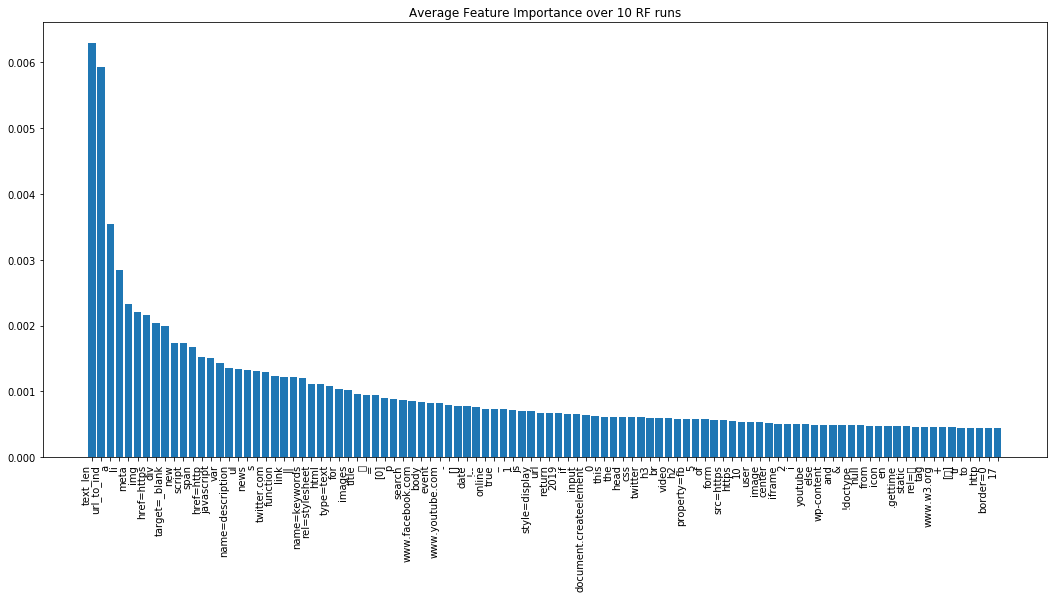

In [16]:
#X = data
#Y = labels
print(len(Y))
print(len(X))
word_dict = {}
acc = 0
plt.figure(figsize=(25,10))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size= 0.6, test_size=0.4, random_state = 11)
for i in range(10):
    #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size= 0.6, test_size=0.4, random_state = i)
    forest = RandomForestClassifier(n_estimators=80, random_state = i )
    forest.fit(X_train,Y_train)
    #print()
    acc+= forest.score(X_test,Y_test)
    #print(*(sorted(list(zip(vocab+['url_to_ind','text_len'],forest.feature_importances_)), key=lambda x: x[1],reverse=True))[:10], sep = '\n')
   # print(classification_report(Y_test,forest.predict(X_test)))
    vals = sorted(list(zip(vocab+['url_to_ind','text_len'],forest.feature_importances_)), key=lambda x: x[1],reverse=True)
    for (x,y) in vals:
        if y > .00000000000000009:
            if x in word_dict.keys():
                word_dict[x] = word_dict.get(x) + y
            else:
                word_dict[x] = y
print(len(word_dict.keys()))
print('avg val accuracy: '+str(acc/10))
q = 100
plt.figure(figsize=(18,8))
words = sorted(list(word_dict.items()),key=lambda x: x[1],reverse=True)
plt.bar(range(q), [y/30 for (x,y) in words[:q]], align='center')
#plt.bar(range(len(word_dict)), word_dict.values(), align='center')
plt.xticks(range(0,q), [x for x,y in words[:q]])
plt.setp(plt.gca().get_xticklabels(), rotation=90, horizontalalignment='right')
plt.title('Average Feature Importance over 10 RF runs')
plt.show()
#forest = RandomForestRegressor(n_estimators=80,random_state=13)
#forest.fit(X_train,Y_train)
#print(forest.score(X_test,Y_test))
#print(*(sorted(list(zip(vocab,forest.feature_importances_)), key=lambda x: x[1],reverse=True))[:100], sep = '\n')


In [40]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=13)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(classification_report(Y_test,clf.predict(X_test)))

0.7623126338329764
             precision    recall  f1-score   support

          0       0.74      0.80      0.77       688
          1       0.79      0.73      0.76       713

avg / total       0.76      0.76      0.76      1401



In [41]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(verbose=True, batch_size= 9, random_state = 15)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(classification_report(Y_test,clf.predict(X_test)))

Iteration 1, loss = 7.07859754
Iteration 2, loss = 5.54814895
Iteration 3, loss = 6.03432564
Iteration 4, loss = 4.51086732
Iteration 5, loss = 4.99308113
Iteration 6, loss = 4.56065442
Iteration 7, loss = 4.02779882
Iteration 8, loss = 3.78573105
Iteration 9, loss = 3.84416501
Iteration 10, loss = 3.06832647
Iteration 11, loss = 5.87989831
Iteration 12, loss = 4.26891367
Iteration 13, loss = 4.10189557
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.7587437544610992
             precision    recall  f1-score   support

          0       0.92      0.55      0.69       688
          1       0.69      0.96      0.80       713

avg / total       0.81      0.76      0.75      1401



In [42]:
clf = MLPClassifier(verbose=True, batch_size= 9, random_state = 13)
clf.fit(X_train,Y_train)
print(clf.score(X_test,Y_test))
print(classification_report(Y_test,clf.predict(X_test)))

Iteration 1, loss = 8.39093788
Iteration 2, loss = 5.08743657
Iteration 3, loss = 6.44394023
Iteration 4, loss = 5.36899329
Iteration 5, loss = 3.57896179
Iteration 6, loss = 4.79216944
Iteration 7, loss = 4.75949613
Iteration 8, loss = 3.75321093
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
0.755174875089222
             precision    recall  f1-score   support

          0       0.70      0.86      0.78       688
          1       0.83      0.65      0.73       713

avg / total       0.77      0.76      0.75      1401



In [111]:
from sklearn.neural_network import MLPClassifier
for i in range(0,30):
    X = pd.DataFrame( data,columns=vocab)#np.column_stack([data,labels])
    X['url_to_ind'] = url_to_ind_distance
    X['text_len'] = text_len
    X['unsafe'] = labels
    X = X.drop_duplicates()
    X1 = X[X['unsafe']==1].sample(frac=1)
    X0 = X[X['unsafe']==0].sample(frac=1)
    if(X0.shape[0] < X1.shape[0]):
        X1 = X1.reset_index(drop=True).loc[:(X0.shape[0]),:]
    else: 
        X0 - X0.reset_index(drop=True).loc[:(X1.shape[0]),:]
    temp_df = pd.concat([X0,X1]).sample(frac=1) 
    X = temp_df.drop(columns=['unsafe'])
    Y = temp_df['unsafe']
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size= 0.5, test_size=0.5, random_state=10*i)
    clf = MLPClassifier(batch_size= 9, random_state = i)
    clf.fit(X_train,Y_train)
    print(clf.score(X_test,Y_test))
    #print(classification_report(Y_test,clf.predict(X_test)))

0.7542799597180262
0.771399798590131
0.7900302114803626
0.7537764350453172
0.8081570996978852
0.7804632426988922
0.7719033232628398
0.7754279959718026
0.7779456193353474
0.5140986908358509
0.622356495468278
0.7829808660624371
0.7829808660624371
0.797079556898288
0.7865055387713998
0.6389728096676737
0.607754279959718
0.43303121852970794
0.7109768378650554
0.6178247734138973
0.7804632426988922
0.7739174219536757
0.7537764350453172
0.7819738167170192
0.7774420946626385
0.7925478348439073
0.7804632426988922
0.6430010070493454
0.7824773413897281
0.7099697885196374


In [83]:
#get new X and Y
X = pd.DataFrame( data,columns=vocab)#np.column_stack([data,labels])
X['url_to_ind'] = url_to_ind_distance
X['text_len'] = text_len
X['unsafe'] = labels
X = X.drop_duplicates()
X1 = X[X['unsafe']==1].sample(frac=1)
X0 = X[X['unsafe']==0].sample(frac=1)
if(X0.shape[0] < X1.shape[0]):
    X1 = X1.reset_index(drop=True).loc[:(X0.shape[0]),:]
else: 
    X0 - X0.reset_index(drop=True).loc[:(X1.shape[0]),:]
temp_df = pd.concat([X0,X1]).sample(frac=1).drop_duplicates() 
X = temp_df.drop(columns=['unsafe'])
Y = temp_df['unsafe']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size= 0.60, test_size=0.40)

Working with Keras to try and improve on this 86-88% accuracy

In [43]:
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Dense(12, input_dim=X_train.shape[1], activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_102 (Dense)            (None, 12)                120036    
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 13        
Total params: 120,049
Trainable params: 120,049
Non-trainable params: 0
_________________________________________________________________


In [44]:
model = Sequential()
model.add(layers.Dense(40, input_dim=X_train.shape[1], activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train,Y_train, epochs=130, verbose=1, validation_data=(X_test,Y_test), batch_size=10)
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))



Train on 2100 samples, validate on 1401 samples
Epoch 1/130
2100/2100 [==============================] - 3s 2ms/step - loss: 2.5584 - acc: 0.4886 - val_loss: 0.6930 - val_acc: 0.5089
Epoch 2/130
2100/2100 [==============================] - 1s 686us/step - loss: 0.9053 - acc: 0.4957 - val_loss: 0.6930 - val_acc: 0.5089
Epoch 3/130
2100/2100 [==============================] - 1s 695us/step - loss: 0.8526 - acc: 0.4924 - val_loss: 0.6929 - val_acc: 0.5089
Epoch 4/130
2100/2100 [==============================] - 1s 703us/step - loss: 0.7546 - acc: 0.4957 - val_loss: 0.6927 - val_acc: 0.5089
Epoch 5/130
2100/2100 [==============================] - 1s 701us/step - loss: 0.7682 - acc: 0.4952 - val_loss: 0.6927 - val_acc: 0.5089
Epoch 6/130
2100/2100 [==============================] - 2s 765us/step - loss: 0.7742 - acc: 0.4938 - val_loss: 0.6927 - val_acc: 0.5089
Epoch 7/130
2100/2100 [==============================] - 2s 769us/step - loss: 0.7596 - acc: 0.4800 - val_loss: 0.6928 - val_acc: 0.

KeyboardInterrupt: 

In [182]:
#tr_acc = []
#te_acc = []
tr_acc20 = []
te_acc20 = []
d_lays = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]

In [188]:
for d in d_lays:
    model = Sequential()
    model.add(layers.Dense(d, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss=, optimizer='adagrad', metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=20, verbose=1, validation_data=(X_test,Y_test), batch_size=10)
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    tr_acc5 = tr_acc5 +[accuracy]
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    te_acc5 = te_acc5 +[accuracy]
    print("Testing Accuracy:  {:.4f}".format(accuracy))

Train on 2227 samples, validate on 1486 samples
Epoch 1/20
2227/2227 [==============================] - 13s 6ms/step - loss: 0.7549 - acc: 0.6057 - val_loss: 0.6707 - val_acc: 0.6265
Epoch 2/20
2227/2227 [==============================] - 1s 384us/step - loss: 0.6344 - acc: 0.6466 - val_loss: 0.6670 - val_acc: 0.6406
Epoch 3/20
2227/2227 [==============================] - 1s 387us/step - loss: 0.6191 - acc: 0.6587 - val_loss: 0.6606 - val_acc: 0.6413
Epoch 4/20
2227/2227 [==============================] - 1s 389us/step - loss: 0.6124 - acc: 0.6753 - val_loss: 0.6562 - val_acc: 0.6534
Epoch 5/20
2227/2227 [==============================] - 1s 386us/step - loss: 0.5995 - acc: 0.6879 - val_loss: 0.6556 - val_acc: 0.6541
Epoch 6/20
2227/2227 [==============================] - 1s 387us/step - loss: 0.5898 - acc: 0.6960 - val_loss: 0.6626 - val_acc: 0.6588
Epoch 7/20
2227/2227 [==============================] - 1s 387us/step - loss: 0.5874 - acc: 0.6996 - val_loss: 0.6738 - val_acc: 0.6581
E

KeyboardInterrupt: 

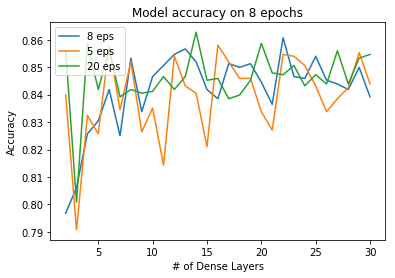

In [196]:
plt.plot(d_lays[1:],te_acc[1:])
plt.plot(d_lays[1:],te_acc5[1:30])
plt.plot(d_lays[1:],te_acc5[31:-6])
plt.title('Model accuracy on 8 epochs')
plt.ylabel('Accuracy')
plt.xlabel('# of Dense Layers')
plt.legend(['8 eps', '5 eps','20 eps'], loc='upper left')
plt.show()

## NN Trials

0
Train on 2100 samples, validate on 1401 samples
Epoch 1/150
2100/2100 [==============================] - 7s 3ms/step - loss: 6.6973 - acc: 0.5081 - val_loss: 6.6699 - val_acc: 0.4918
Epoch 2/150
2100/2100 [==============================] - 1s 641us/step - loss: 3.6948 - acc: 0.5648 - val_loss: 1.8649 - val_acc: 0.5767
Epoch 3/150
2100/2100 [==============================] - 1s 640us/step - loss: 1.7241 - acc: 0.6062 - val_loss: 1.3539 - val_acc: 0.6403
Epoch 4/150
2100/2100 [==============================] - 1s 644us/step - loss: 1.2757 - acc: 0.6586 - val_loss: 1.4351 - val_acc: 0.6424
Epoch 5/150
2100/2100 [==============================] - 1s 642us/step - loss: 1.3370 - acc: 0.6552 - val_loss: 1.4609 - val_acc: 0.6438
Epoch 6/150
2100/2100 [==============================] - 1s 642us/step - loss: 1.1029 - acc: 0.6905 - val_loss: 1.0505 - val_acc: 0.6931
Epoch 7/150
2100/2100 [==============================] - 1s 644us/step - loss: 1.0091 - acc: 0.7000 - val_loss: 0.9528 - val_acc: 

Epoch 60/150
2100/2100 [==============================] - 1s 656us/step - loss: 0.7598 - acc: 0.7095 - val_loss: 0.8247 - val_acc: 0.6945
Epoch 61/150
2100/2100 [==============================] - 1s 658us/step - loss: 0.7591 - acc: 0.7124 - val_loss: 0.8236 - val_acc: 0.6952

Epoch 00061: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Epoch 62/150
2100/2100 [==============================] - 1s 663us/step - loss: 0.7569 - acc: 0.7133 - val_loss: 0.8227 - val_acc: 0.6966
Epoch 63/150
2100/2100 [==============================] - 1s 653us/step - loss: 0.7565 - acc: 0.7110 - val_loss: 0.8208 - val_acc: 0.6974
Restoring model weights from the end of the best epoch
Epoch 00063: early stopping
Training Accuracy: 0.7095
Testing Accuracy:  0.6981
3
Train on 2100 samples, validate on 1401 samples
Epoch 1/150
2100/2100 [==============================] - 8s 4ms/step - loss: 7.5645 - acc: 0.4938 - val_loss: 7.2873 - val_acc: 0.5082
Epoch 2/150
2100/2100 [========================

2100/2100 [==============================] - 1s 668us/step - loss: 0.7175 - acc: 0.7229 - val_loss: 0.8251 - val_acc: 0.7074
Epoch 16/150
2100/2100 [==============================] - 1s 666us/step - loss: 0.7106 - acc: 0.7186 - val_loss: 0.7844 - val_acc: 0.7266
Epoch 17/150
2100/2100 [==============================] - 1s 664us/step - loss: 0.7222 - acc: 0.7233 - val_loss: 0.7514 - val_acc: 0.7323
Epoch 18/150
2100/2100 [==============================] - 1s 686us/step - loss: 0.6828 - acc: 0.7457 - val_loss: 0.7288 - val_acc: 0.7388
Epoch 19/150
2100/2100 [==============================] - 1s 677us/step - loss: 0.6575 - acc: 0.7419 - val_loss: 0.7155 - val_acc: 0.7473
Epoch 20/150
2100/2100 [==============================] - 1s 680us/step - loss: 0.6350 - acc: 0.7548 - val_loss: 0.7311 - val_acc: 0.7266
Epoch 21/150
2100/2100 [==============================] - 1s 673us/step - loss: 0.6345 - acc: 0.7505 - val_loss: 0.7025 - val_acc: 0.7380
Epoch 22/150
2100/2100 [=======================

Epoch 4/150
2100/2100 [==============================] - 1s 671us/step - loss: 1.1624 - acc: 0.6438 - val_loss: 1.2430 - val_acc: 0.6488
Epoch 5/150
2100/2100 [==============================] - 1s 666us/step - loss: 1.1110 - acc: 0.6567 - val_loss: 1.1414 - val_acc: 0.6552
Epoch 6/150
2100/2100 [==============================] - 1s 668us/step - loss: 1.0503 - acc: 0.6652 - val_loss: 1.0792 - val_acc: 0.6688
Epoch 7/150
2100/2100 [==============================] - 1s 669us/step - loss: 1.0360 - acc: 0.6757 - val_loss: 1.0308 - val_acc: 0.6781
Epoch 8/150
2100/2100 [==============================] - 1s 669us/step - loss: 1.0039 - acc: 0.6881 - val_loss: 1.0320 - val_acc: 0.6909
Epoch 9/150
2100/2100 [==============================] - 1s 674us/step - loss: 0.9721 - acc: 0.6929 - val_loss: 1.0054 - val_acc: 0.6945
Epoch 10/150
2100/2100 [==============================] - 1s 668us/step - loss: 0.9380 - acc: 0.6933 - val_loss: 1.0151 - val_acc: 0.6981
Epoch 11/150
2100/2100 [================

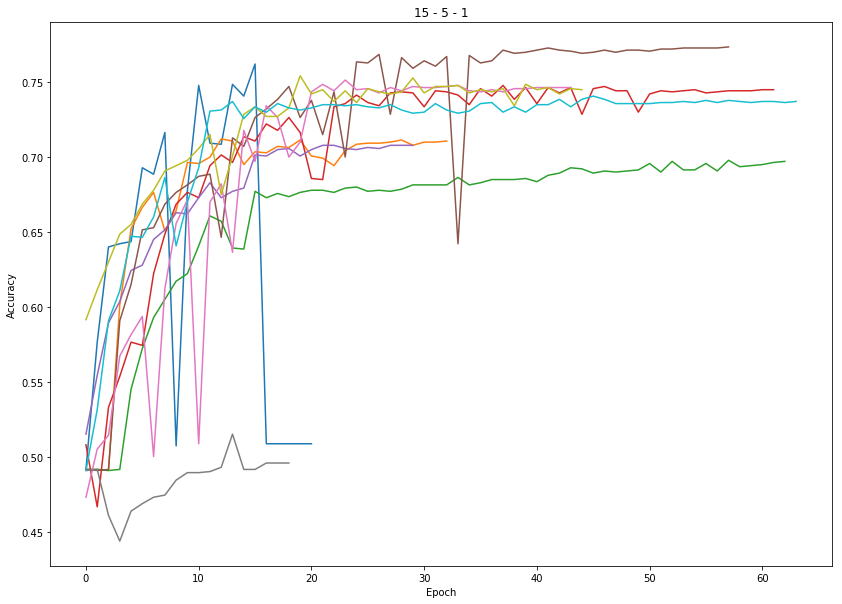

In [52]:
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from numpy.random import seed
callbacks = [EarlyStopping(monitor='val_loss', min_delta=.0001, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
plt.figure(figsize=(14,10))
for i in range(10):
    print(i)
    seed(i)
    model = Sequential()
    model.add(layers.Dense(15, input_dim=X_train.shape[1], activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(5, activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=150, verbose=1, callbacks=callbacks, validation_data=(X_test,Y_test), batch_size=10)
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('15 - 5 - 1')
plt.show()

0
Train on 2100 samples, validate on 1401 samples
Epoch 1/150
2100/2100 [==============================] - 13s 6ms/step - loss: 7.5525 - acc: 0.4924 - val_loss: 7.2991 - val_acc: 0.5082
Epoch 2/150
2100/2100 [==============================] - 1s 709us/step - loss: 7.4947 - acc: 0.4919 - val_loss: 7.2475 - val_acc: 0.5082
Epoch 3/150
2100/2100 [==============================] - 1s 714us/step - loss: 7.4325 - acc: 0.4914 - val_loss: 7.1730 - val_acc: 0.5082
Epoch 4/150
2100/2100 [==============================] - 1s 713us/step - loss: 7.3144 - acc: 0.4910 - val_loss: 6.9745 - val_acc: 0.5075
Epoch 5/150
2100/2100 [==============================] - 2s 721us/step - loss: 5.4087 - acc: 0.4876 - val_loss: 1.2389 - val_acc: 0.5132
Epoch 6/150
2100/2100 [==============================] - 1s 712us/step - loss: 0.8305 - acc: 0.5314 - val_loss: 0.7138 - val_acc: 0.5639
Epoch 7/150
2100/2100 [==============================] - 1s 713us/step - loss: 0.7290 - acc: 0.5657 - val_loss: 0.6829 - val_acc:

2100/2100 [==============================] - 2s 725us/step - loss: 0.5832 - acc: 0.7971 - val_loss: 0.7406 - val_acc: 0.7580
Epoch 37/150
2100/2100 [==============================] - 2s 728us/step - loss: 0.5857 - acc: 0.7929 - val_loss: 0.7458 - val_acc: 0.7566
Epoch 38/150
2100/2100 [==============================] - 2s 721us/step - loss: 0.5833 - acc: 0.7910 - val_loss: 0.7361 - val_acc: 0.7616
Epoch 39/150
2100/2100 [==============================] - 2s 740us/step - loss: 0.5826 - acc: 0.7910 - val_loss: 0.7345 - val_acc: 0.7587
Epoch 40/150
2100/2100 [==============================] - 2s 722us/step - loss: 0.5768 - acc: 0.7967 - val_loss: 0.7395 - val_acc: 0.7623
Epoch 41/150
2100/2100 [==============================] - 2s 727us/step - loss: 0.5749 - acc: 0.7990 - val_loss: 0.7448 - val_acc: 0.7559
Epoch 42/150
2100/2100 [==============================] - 2s 723us/step - loss: 0.5745 - acc: 0.7971 - val_loss: 0.7414 - val_acc: 0.7559

Epoch 00042: ReduceLROnPlateau reducing learni

2100/2100 [==============================] - 2s 737us/step - loss: 0.5057 - acc: 0.7981 - val_loss: 0.6889 - val_acc: 0.7659
Epoch 42/150
2100/2100 [==============================] - 2s 733us/step - loss: 0.5054 - acc: 0.7971 - val_loss: 0.6890 - val_acc: 0.7659
Epoch 43/150
2100/2100 [==============================] - 2s 738us/step - loss: 0.5054 - acc: 0.7986 - val_loss: 0.6889 - val_acc: 0.7680
Epoch 44/150
2100/2100 [==============================] - 2s 733us/step - loss: 0.5053 - acc: 0.7976 - val_loss: 0.6889 - val_acc: 0.7680

Epoch 00044: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Epoch 45/150
2100/2100 [==============================] - 2s 738us/step - loss: 0.5048 - acc: 0.7957 - val_loss: 0.6889 - val_acc: 0.7680
Epoch 46/150
2100/2100 [==============================] - 2s 739us/step - loss: 0.5048 - acc: 0.7962 - val_loss: 0.6889 - val_acc: 0.7687
Restoring model weights from the end of the best epoch
Epoch 00046: early stopping
Training Accuracy: 0

Epoch 2/150
2100/2100 [==============================] - 2s 746us/step - loss: 2.0252 - acc: 0.5714 - val_loss: 2.0300 - val_acc: 0.5675
Epoch 3/150
2100/2100 [==============================] - 2s 742us/step - loss: 1.6424 - acc: 0.6067 - val_loss: 1.4843 - val_acc: 0.6260
Epoch 4/150
2100/2100 [==============================] - 2s 741us/step - loss: 1.8284 - acc: 0.6190 - val_loss: 1.4181 - val_acc: 0.6303
Epoch 5/150
2100/2100 [==============================] - 2s 740us/step - loss: 1.3351 - acc: 0.6514 - val_loss: 1.2985 - val_acc: 0.6460
Epoch 6/150
2100/2100 [==============================] - 2s 746us/step - loss: 1.1932 - acc: 0.6624 - val_loss: 1.3912 - val_acc: 0.6424
Epoch 7/150
2100/2100 [==============================] - 2s 741us/step - loss: 1.5061 - acc: 0.6676 - val_loss: 4.7484 - val_acc: 0.5253
Epoch 8/150
2100/2100 [==============================] - 2s 739us/step - loss: 1.2539 - acc: 0.6781 - val_loss: 1.1357 - val_acc: 0.6859
Epoch 9/150
2100/2100 [==================

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlim'

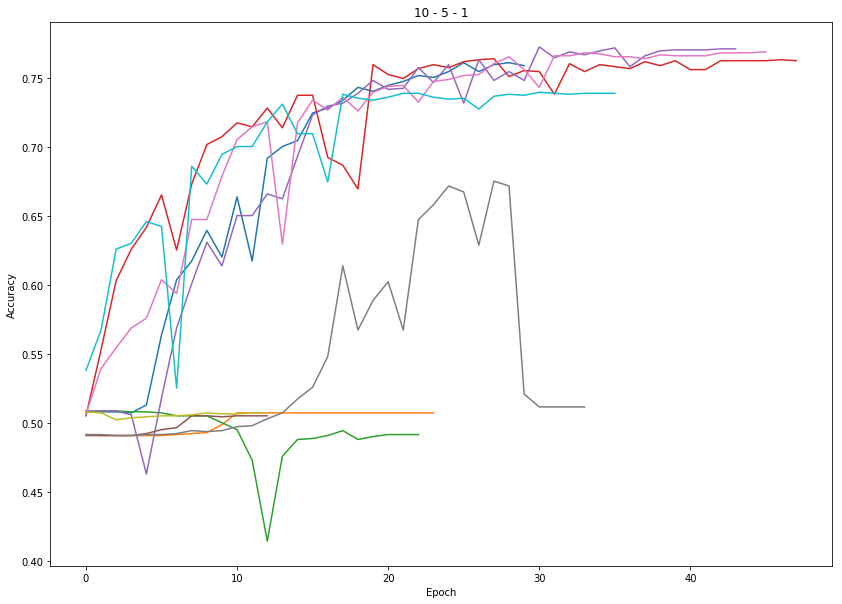

In [61]:
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from numpy.random import seed
callbacks = [EarlyStopping(monitor='val_loss', min_delta=.0001, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
plt.figure(figsize=(14,10))
for i in range(10):
    print(i)
    seed(i)
    model = Sequential()
    model.add(layers.Dense(10, input_dim=X_train.shape[1], activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(5, activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=150, verbose=1, callbacks=callbacks, validation_data=(X_test,Y_test), batch_size=10)
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('10 - 5 - 1')
plt.set_xlim(top=65)
plt.show()

0
Train on 2100 samples, validate on 1401 samples
Epoch 1/150
2100/2100 [==============================] - 8s 4ms/step - loss: 7.3206 - acc: 0.4914 - val_loss: 6.2600 - val_acc: 0.4946
Epoch 2/150
2100/2100 [==============================] - 1s 586us/step - loss: 1.8512 - acc: 0.5614 - val_loss: 1.5109 - val_acc: 0.5403
Epoch 3/150
2100/2100 [==============================] - 1s 558us/step - loss: 1.3903 - acc: 0.5657 - val_loss: 1.4308 - val_acc: 0.5703
Epoch 4/150
2100/2100 [==============================] - 1s 569us/step - loss: 1.2594 - acc: 0.5919 - val_loss: 1.3164 - val_acc: 0.5867
Epoch 5/150
2100/2100 [==============================] - 1s 557us/step - loss: 1.2067 - acc: 0.6133 - val_loss: 1.2810 - val_acc: 0.6010
Epoch 6/150
2100/2100 [==============================] - 1s 566us/step - loss: 1.1472 - acc: 0.6357 - val_loss: 1.1312 - val_acc: 0.6246
Epoch 7/150
2100/2100 [==============================] - 1s 559us/step - loss: 1.0100 - acc: 0.6495 - val_loss: 1.0458 - val_acc: 

Epoch 5/150
2100/2100 [==============================] - 1s 574us/step - loss: 6.2990 - acc: 0.5090 - val_loss: 6.4516 - val_acc: 0.4918
Epoch 6/150
2100/2100 [==============================] - 1s 693us/step - loss: 6.1682 - acc: 0.5081 - val_loss: 6.3161 - val_acc: 0.4911
Epoch 7/150
2100/2100 [==============================] - 1s 639us/step - loss: 6.0091 - acc: 0.5086 - val_loss: 6.1374 - val_acc: 0.4911
Epoch 8/150
2100/2100 [==============================] - 1s 569us/step - loss: 5.7335 - acc: 0.5090 - val_loss: 5.7947 - val_acc: 0.4939
Epoch 9/150
2100/2100 [==============================] - 1s 571us/step - loss: 5.1789 - acc: 0.5124 - val_loss: 4.8842 - val_acc: 0.5018
Epoch 10/150
2100/2100 [==============================] - 1s 573us/step - loss: 2.0738 - acc: 0.5924 - val_loss: 1.1327 - val_acc: 0.6467
Epoch 11/150
2100/2100 [==============================] - 1s 569us/step - loss: 1.0771 - acc: 0.6557 - val_loss: 1.0162 - val_acc: 0.6652
Epoch 12/150
2100/2100 [===============

2100/2100 [==============================] - 1s 581us/step - loss: 1.2248 - acc: 0.6571 - val_loss: 1.2801 - val_acc: 0.6510
Epoch 18/150
2100/2100 [==============================] - 1s 579us/step - loss: 1.2056 - acc: 0.6676 - val_loss: 1.2317 - val_acc: 0.6717
Epoch 19/150
2100/2100 [==============================] - 1s 579us/step - loss: 1.1373 - acc: 0.6852 - val_loss: 1.3504 - val_acc: 0.6431
Epoch 20/150
2100/2100 [==============================] - 1s 576us/step - loss: 1.1239 - acc: 0.6762 - val_loss: 1.2569 - val_acc: 0.6617
Epoch 21/150
2100/2100 [==============================] - 1s 578us/step - loss: 1.0640 - acc: 0.6881 - val_loss: 1.1898 - val_acc: 0.6845
Epoch 22/150
2100/2100 [==============================] - 1s 579us/step - loss: 1.0900 - acc: 0.6876 - val_loss: 1.1377 - val_acc: 0.6916
Epoch 23/150
2100/2100 [==============================] - 1s 578us/step - loss: 0.9863 - acc: 0.7119 - val_loss: 1.1181 - val_acc: 0.6966
Epoch 24/150
2100/2100 [=======================

2100/2100 [==============================] - 1s 582us/step - loss: 0.6926 - acc: 0.5119 - val_loss: 0.6936 - val_acc: 0.4932

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 14/150
2100/2100 [==============================] - 1s 698us/step - loss: 0.6925 - acc: 0.5129 - val_loss: 0.6936 - val_acc: 0.4939
Epoch 15/150
2100/2100 [==============================] - 1s 581us/step - loss: 0.6925 - acc: 0.5129 - val_loss: 0.6936 - val_acc: 0.4946
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping
Training Accuracy: 0.5105
Testing Accuracy:  0.4918
9
Train on 2100 samples, validate on 1401 samples
Epoch 1/150
2100/2100 [==============================] - 9s 4ms/step - loss: 2.8209 - acc: 0.5390 - val_loss: 1.4554 - val_acc: 0.5789
Epoch 2/150
2100/2100 [==============================] - 1s 588us/step - loss: 1.3228 - acc: 0.5881 - val_loss: 1.1955 - val_acc: 0.6096
Epoch 3/150
2100/2100 [==============================] - 1s 5

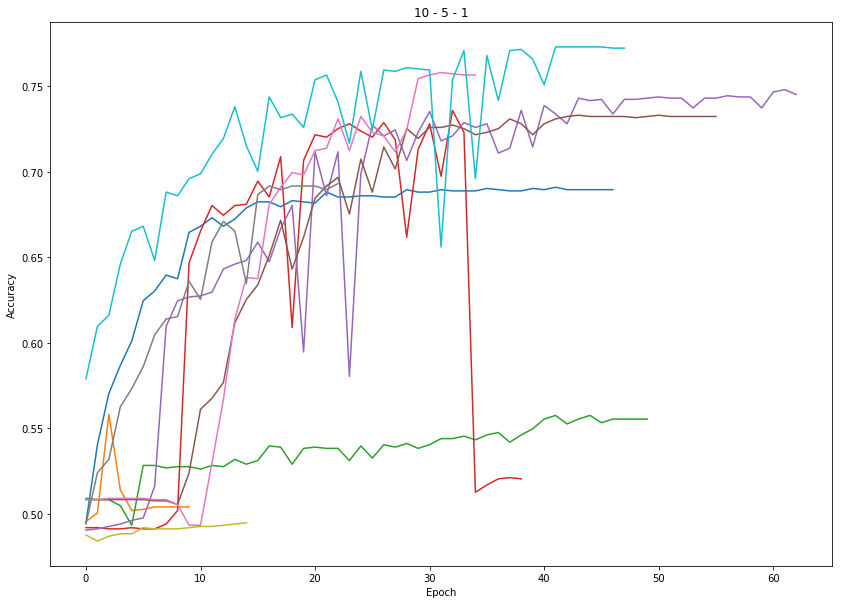

In [53]:
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from numpy.random import seed
callbacks = [EarlyStopping(monitor='val_loss', min_delta=.0001, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
plt.figure(figsize=(14,10))
for i in range(10):
    print(i)
    seed(i)
    model = Sequential()
    model.add(layers.Dense(5, input_dim=X_train.shape[1], activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=150, verbose=1, callbacks=callbacks, validation_data=(X_test,Y_test), batch_size=10)
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('5 - 10 - 1')
plt.show()

0

Epoch 00022: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Restoring model weights from the end of the best epoch
Epoch 00045: early stopping
Training Accuracy: 0.7986
Testing Accuracy:  0.7580
1

Epoch 00015: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Restoring model weights from the end of the best epoch
Epoch 00035: early stopping
Training Accuracy: 0.7390
Testing Accuracy:  0.7281
2

Epoch 00030: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Restoring model weights from the end of the best epoch
Epoch 00032: early stopping
Training Accuracy: 0.5371
Testing Accuracy:  0.5203
3

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00040: Reduc

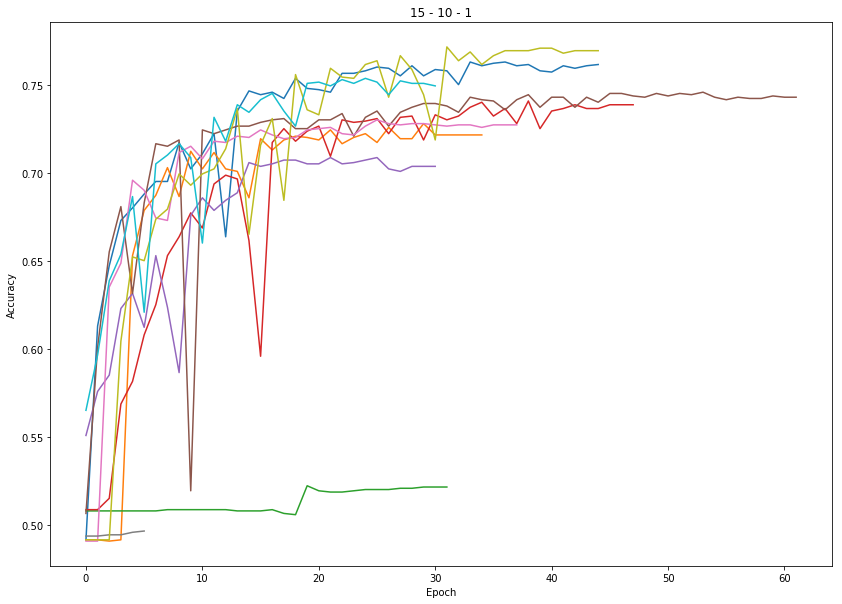

In [54]:
#appears best at a glance
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from numpy.random import seed
callbacks = [EarlyStopping(monitor='val_loss', min_delta=.0001, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
plt.figure(figsize=(14,10))
for i in range(10):
    print(i)
    seed(i)
    model = Sequential()
    model.add(layers.Dense(15, input_dim=X_train.shape[1], activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=150, verbose=0, callbacks=callbacks, validation_data=(X_test,Y_test), batch_size=10)
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('15 - 10 - 1')
plt.show()

0

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00026: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Restoring model weights from the end of the best epoch
Epoch 00034: early stopping
Training Accuracy: 0.7971
Testing Accuracy:  0.7616
1

Epoch 00035: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Restoring model weights from the end of the best epoch
Epoch 00037: early stopping
Training Accuracy: 0.8167
Testing Accuracy:  0.7687
2

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00041: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Restoring model weights from the end of the best epoch
Epoch 00043: early stopping
Training Accuracy: 0.7476
Testing Accuracy:  0.7223
3

Epoch 00022: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00050: Reduc

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlim'

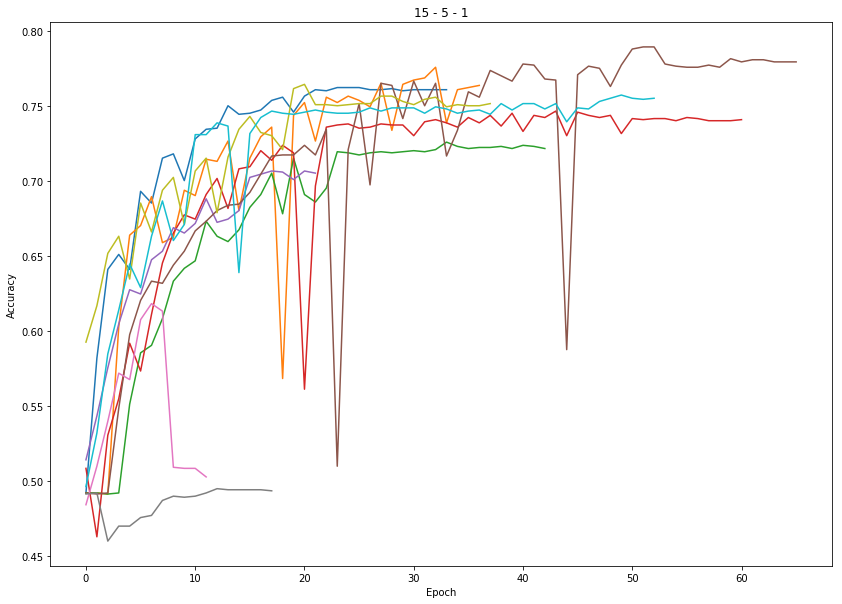

In [60]:
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from numpy.random import seed
callbacks = [EarlyStopping(monitor='val_loss', min_delta=.0001, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
plt.figure(figsize=(14,10))

for i in range(10):
    print(i)
    seed(i)
    model = Sequential()
    model.add(layers.Dense(15, input_dim=X_train.shape[1], activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(5, activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=150, verbose=0, callbacks=callbacks, validation_data=(X_test,Y_test), batch_size=10)
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('15 - 5 - 1')
plt.set_xlim(top=65)
plt.show()

0

Epoch 00034: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00047: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Restoring model weights from the end of the best epoch
Epoch 00049: early stopping
Training Accuracy: 0.8171
Testing Accuracy:  0.7859
1

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Restoring model weights from the end of the best epoch
Epoch 00034: early stopping
Training Accuracy: 0.7714
Testing Accuracy:  0.7402
2

Epoch 00017: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00036: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00043: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Restoring model weights from the end of the best epoch
Epoch 00045: early 

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xlim'

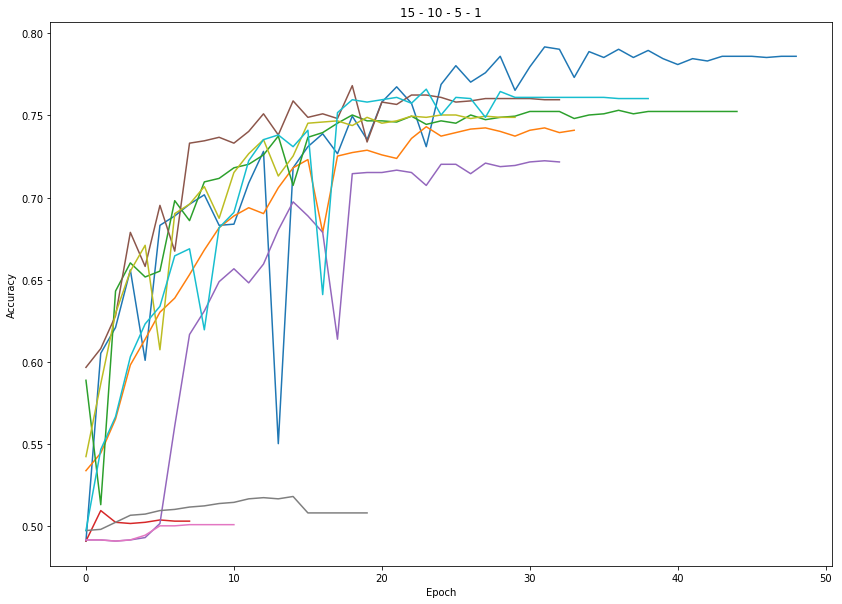

In [62]:
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from numpy.random import seed
callbacks = [EarlyStopping(monitor='val_loss', min_delta=.0001, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
plt.figure(figsize=(14,10))

for i in range(10):
    print(i)
    seed(i)
    model = Sequential()
    model.add(layers.Dense(15, input_dim=X_train.shape[1], activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(5, activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=150, verbose=0, callbacks=callbacks, validation_data=(X_test,Y_test), batch_size=10)
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('15 - 10 - 5 - 1')
plt.set_xlim(top=65)
plt.show()

0

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00028: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Restoring model weights from the end of the best epoch
Epoch 00030: early stopping
Training Accuracy: 0.7571
Testing Accuracy:  0.7516
1

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Restoring model weights from the end of the best epoch
Epoch 00018: early stopping
Training Accuracy: 0.4881
Testing Accuracy:  0.5032
2

Epoch 00035: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
Restoring model weights from the end of the best epoch
Epoch 00048: early stopping
Training Accuracy: 0.7871
Testing Accuracy:  0.7445
3

Epoch 00045: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00072: Reduc

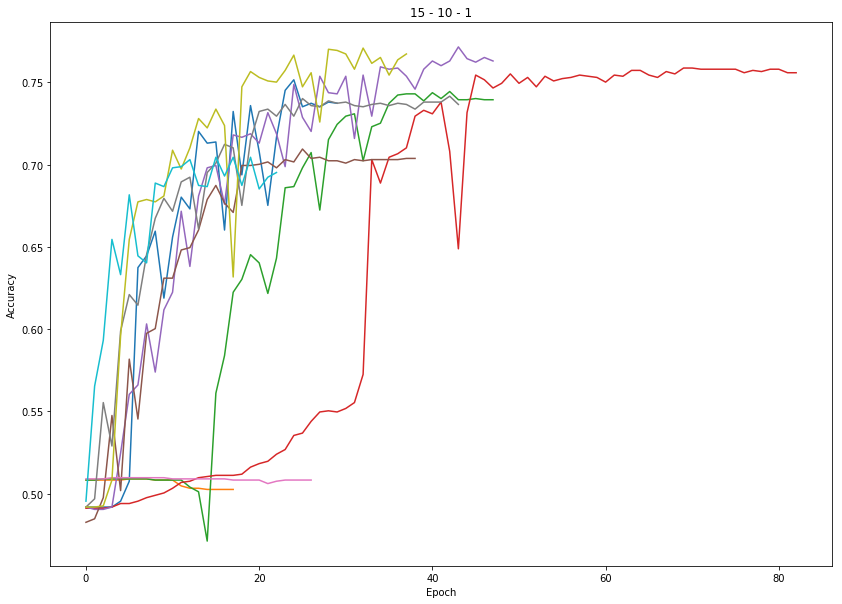

In [63]:
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from numpy.random import seed
callbacks = [EarlyStopping(monitor='val_loss', min_delta=.0001, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
plt.figure(figsize=(14,10))
for i in range(10):
    print(i)
    seed(i)
    model = Sequential()
    model.add(layers.Dense(15, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dropout(0.05))
    model.add(layers.Dense(10, activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=150, verbose=0, callbacks=callbacks, validation_data=(X_test,Y_test), batch_size=10)
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('15 - 10 - 1')
plt.show()

0

Epoch 00012: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00035: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00039: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.

Epoch 00044: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
Restoring model weights from the end of the best epoch
Epoch 00046: early stopping
Training Accuracy: 0.7652
Testing Accuracy:  0.7416
1

Epoch 00016: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Restoring model weights from the end of the best epoch
Epoch 00035: early stopping
Training Accuracy: 0.7400
Testing Accuracy:  0.7231
2

Epoch 00024: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Restoring model weights from the end of the best epoch
Epoch 00026: early stopping
Training Accuracy: 0.5367
Testing Accuracy:  0.5225
3

Epoch 00023: Reduc

Training Accuracy: 0.8090
Testing Accuracy:  0.7666
24

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00020: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
Restoring model weights from the end of the best epoch
Epoch 00022: early stopping
Training Accuracy: 0.7557
Testing Accuracy:  0.7466


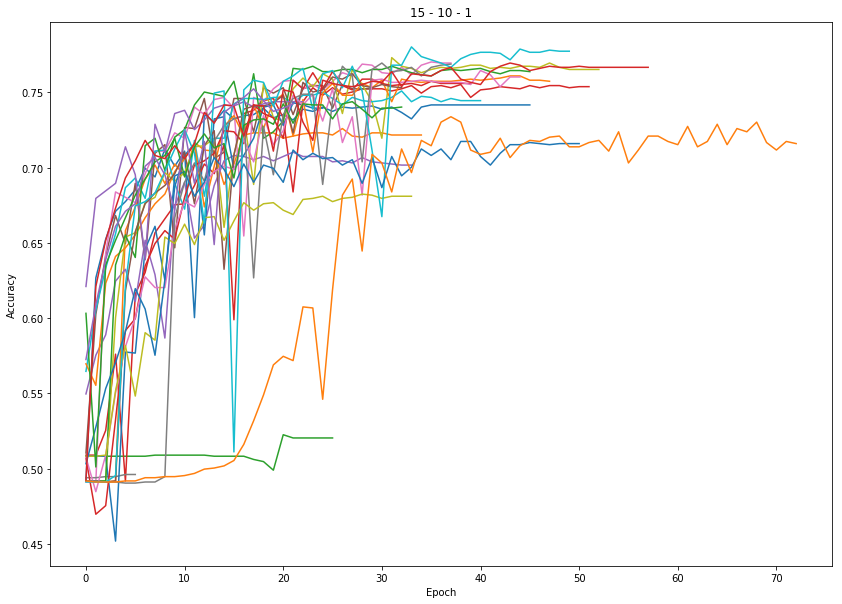

In [64]:
#appears best at a glance
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from numpy.random import seed
callbacks = [EarlyStopping(monitor='val_loss', min_delta=.0001, patience=5, verbose=1, mode='auto', baseline=None, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
plt.figure(figsize=(14,10))
for i in range(25):
    print(i)
    seed(i)
    model = Sequential()
    model.add(layers.Dense(15, input_dim=X_train.shape[1], activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(10, activation='relu'))
    #model.add(layers.Dropout(0.1))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=['accuracy'])
    history = model.fit(X_train,Y_train, epochs=150, verbose=0, callbacks=callbacks, validation_data=(X_test,Y_test), batch_size=10)
    loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title('15 - 10 - 1')
plt.set_xlim(top=65)
plt.show()